# 练习方案：大语言模型文本分析全流程 
## 重要说明
1. 环境： 强烈建议使用 **Google Colab**。它提供免费的GPU（运行Hugging Face模型会快很多），并且很多库已经预装好了，能省去不少配置麻烦。
2. **代码逐步运行：** 建议你在Colab或Jupyter Notebook中，一段一段地运行代码，观察每一步的输出，理解代码的作用。
---
### **第0步：准备工作 - 安装必要的库**
- **目的：** 安装我们进行**数据处理、文本分析、模型调用和可视化**所需的Python库。我们将安装:
    - pandas (数据处理)
    - numpy (数值计算)
    - torch (深度学习框架，Hugging Face依赖)
    - transformers (核心模型库)
    - accelerate (加速)
    - datasets
    - jieba (分词)
    - opencc (简繁转换)
    - wordcloud (词云)
    - matplotlib/seaborn (绘图)
    - gensim (主题模型)
    这是我们整个流程需要用到的工具箱。
- **原因与依据**:
    - pandas 和 numpy: Python数据分析的基础，用于处理**表格数据**（你的CSV）。
    - torch: PyTorch是*Hugging Face transformers库*依赖的**主要深度学习框架**。
    - transformers: *Hugging Face*的核心库，用于**加载和使用预训练的LLM模型**。
    - accelerate, datasets: *Hugging Face*生态系统中的库，有助于**模型加载、训练和数据处理**。
    - jieba: 最流行的Python**中文分词库**，中文文本分析的基础步骤。
    - opencc-python-reimplemented: 用于中文**简繁体转换**，统一文本格式。
    - gensim: 强大的**主题建模库**，包含LDA等算法。
    - wordcloud: 用于**生成词云图**，直观展示高频词。
    - matplotlib, seaborn: Python中最常用的**数据可视化库**，用于绘制各种图表。

- 代码:
```bash
# 安装核心库
pip install pandas numpy torch transformers accelerate datasets # accelerate 和 datasets 通常是transformers的好搭档
# 安装中文处理和可视化库
pip install jieba wordcloud matplotlib seaborn opencc-python-reimplemented
# 安装主题建模库
pip install gensim
# 升级pip和一些基础库可能是个好习惯
pip install --upgrade pip numpy pandas

# transformers[torch]: 安装Hugging Face Transformers库及其PyTorch依赖
# accelerate: Hugging Face推荐的加速库，accelerate 和 datasets 通常是transformers的好搭档
# jieba: 中文分词库
# opencc-python-reimplemented: 简繁体转换库
# wordcloud: 生成词云图
# matplotlib, seaborn: 数据可视化
# gensim: 主题建模库

### **第1步：导入库并加载数据**
**目的：** 准备好编程环境，并将你的新闻数据加载到内存中进行处理。
#### 1.1 导入必备库及配置中文字体
- 导入库： `import ...` 语句告诉Python我们要使用哪些工具。
- 中文显示： `plt.rcParams` 的设置是为了让 `matplotlib` 绘制的图表能正确显示中文，否则可能会是方框。`SimHei` 是常用的中文字体，如果你的环境没有，需要安装或换一个可用的字体。(一般是有的)

In [1]:
# --- 基础数据处理库 ---
import pandas as pd
import numpy as np
import re # 正则表达式库，用于文本清洗
from collections import Counter # 用于计数，如词频统计

# --- 中文处理库 ---
import jieba # 中文分词
import opencc # 简繁转换
from wordcloud import WordCloud # 词云生成

In [2]:
# --- 可视化库 ---
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# --- Hugging Face 相关库 ---
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, AutoModelForTokenClassification, AutoModelForSeq2SeqLM
import torch


In [4]:
# 导入主题建模库
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel



In [5]:
# --- 其他辅助库 ---
from tqdm.notebook import tqdm # 漂亮的进度条 (在Colab或Jupyter中)
import warnings
warnings.filterwarnings('ignore') # 忽略一些不影响结果的警告信息
print("库导入完成。")

库导入完成。


In [6]:
# --- 配置matplotlib支持中文显示 ---
# windows通过plt.rcParams['font.sans-serif'] = ['SimHei'] 指定默认字体simhei即可
# Colab/Linux/Mac 可能需要先安装字体:
# !apt-get update -y
# !apt-get install -y fonts-wqy-zenhei
# plt.rcParams['font.family'] = ['sans-serif'] # Colab 默认可能无SimHei，用系统自带或安装的
# plt.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei'] # 使用文泉驿正黑
# 或者如果你上传了SimHei.ttf: plt.rcParams['font.family'] = ['SimHei']
try:
    plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体为 SimHei
    plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
    print("Matplotlib 中文字体设置成功 (SimHei)。")
except:
    print("警告：SimHei 字体未找到，中文可能显示为方块。请尝试安装或更换字体。")
    
    # 在 Colab 中可以尝试: !apt-get install -y fonts-wqy-zenhei
    # 然后设置 plt.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei']
    # except:
    # try:
        # 如果SimHei失败，尝试系统可能有的字体 (例如 Colab)
        # plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP', 'WenQuanYi Zen Hei']
        # plt.rcParams['axes.unicode_minus'] = False
        # print("SimHei 未找到，已尝试设置 Noto Sans CJK JP 或 WenQuanYi Zen Hei 作为备选")
    # except:
        # print("警告：未能成功设置中文字体，部分图表中文可能显示为方块。请检查字体安装情况。")


Matplotlib 中文字体设置成功 (SimHei)。


#### 使用GPU运行大模型
使用GPU运行大模型可以显著提高运行速度，但在此之前我们先得确认GPU与pytorch、cuda、huggingface是否适配
- `torch.cuda.is_available()`: 这是最权威的检查方法，直接告诉你PyTorch能否找到并使用CUDA。如果返回False，后续步骤都无法使用GPU。
- `torch.cuda.device_count(), torch.cuda.current_device(), torch.cuda.get_device_name(0)`: 这些函数帮助你确认系统识别了多少个GPU，当前默认是哪个，以及它的具体型号，确保是你的3090。
尝试创建GPU张量 `(.cuda())`: 这是一个实际操作，如果能成功，进一步证明PyTorch与CUDA驱动之间的通信是正常的。

In [7]:
# 1. 检查CUDA是否可用
is_cuda_available = torch.cuda.is_available()
print(f"CUDA (GPU支持) 是否可用: {is_cuda_available}")

if is_cuda_available:
    # 2. 获取可用的GPU数量
    gpu_count = torch.cuda.device_count()
    print(f"检测到的GPU数量: {gpu_count}")

    # 3. 获取当前默认使用的GPU索引 (通常是0)
    current_device_index = torch.cuda.current_device()
    print(f"当前默认GPU索引: {current_device_index}")

    # 4. 获取第一个GPU (索引为0) 的名称
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU 0 的名称: {gpu_name}")

    # 检查GPU名称是否符合你的4050
    if "4050" in gpu_name:
        print("检测到RTX 4050 GPU，环境配置基本正确！")
    else:
        print(f"警告：检测到的GPU名称为 '{gpu_name}'，请确认是否是你的目标GPU。")

    # (可选) 尝试在GPU上创建一个张量
    try:
        tensor_gpu = torch.tensor([1.0, 2.0]).cuda()
        print(f"成功在GPU上创建张量: {tensor_gpu}, 设备: {tensor_gpu.device}")
    except Exception as e:
        print(f"尝试在GPU上创建张量失败: {e}")
        print("这可能意味着CUDA环境或PyTorch安装存在问题。")
    torch.cuda.empty_cache() # 尝试释放未被占用的缓存显存

else:
    print("错误：PyTorch未能检测到可用的CUDA环境。请检查你的CUDA安装、NVIDIA驱动以及PyTorch是否是GPU版本。")

CUDA (GPU支持) 是否可用: True
检测到的GPU数量: 1
当前默认GPU索引: 0
GPU 0 的名称: NVIDIA GeForce RTX 4050 Laptop GPU
检测到RTX 4050 GPU，环境配置基本正确！
成功在GPU上创建张量: tensor([1., 2.], device='cuda:0'), 设备: cuda:0


#### 1.2 加载数据
- **加载CSV：** `pd.read_csv()` 是 `pandas` 库读取CSV文件的核心函数。我们把它读入一个名为 `df` 的DataFrame（可以理解为**带标签的表格**）。
- **初步检查：** `.head()` 显示前几行，让你看看数据长什么样。`.info()` 显示每列的名称、非空数量和数据类型。`.isnull().sum()` 统计每列有多少缺失值。这些是拿到数据后必做的检查。
- **时间转换：** `pd.to_datetime()` 非常重要，它把文本格式的时间（如 '2025-04-10 00:02:00'）转换成Python能理解的时间对象，这样才能按时间排序、筛选和聚合。`errors='coerce'` 让转换失败的值变成`NaT`（缺失时间），`dropna` 则删掉这些行。
- 时期与来源： 因为练习数据没有明确的时期和来源分类，我们暂时手动添加了 **period 和 source 列**作为示例。在你处理其他数据时，需要根据实际情况（比如用时间戳判断时期，或者你的数据本身就有来源列）来创建或使用这些列。

In [8]:
file_path = "merged_news_data.csv"
df = pd.read_csv(file_path)
print(f"成功从 '{file_path}' 加载数据。")

成功从 'merged_news_data.csv' 加载数据。


In [9]:
# --- 数据初步检查 ---
print("\n数据前5行预览:")
print(df.head())

print(f"\n数据总行数: {len(df)}")


数据前5行预览:
                                 headline  \
0                              我们不惹事，也不怕事   
1  海关总署：4月10日12时01分起，执行对原产于美国的进口商品加征84%关税   
2                        北京市气象台发布重要天气提示信息   
3            极端大风➕强降温！明天上午北京将提前发布大风橙色预警信号   
4                       教育部发布2025年第1号留学预警   

                                                 url                 time  \
0  https://news.sina.com.cn/c/2025-04-10/doc-ines...  2025-04-10 00:02:00   
1  https://news.sina.com.cn/c/2025-04-09/doc-ines...  2025-04-09 23:10:00   
2  https://news.sina.com.cn/c/2025-04-09/doc-ines...  2025-04-09 22:49:00   
3  https://news.sina.com.cn/c/2025-04-09/doc-ines...  2025-04-09 22:42:00   
4  https://news.sina.com.cn/c/2025-04-09/doc-ines...  2025-04-09 22:21:00   

                                             summary  \
0  来源：央视网 美国对全球滥施关税的“余震”还在继续，全球经济遭遇“黑色星期一”。 4月7日至...   
1  海关总署4月9日发文称，根据《国务院关税税则委员会关于对原产于美国的进口商品加征关税的公告》...   
2  受冷涡加强东移南下影响，11日下午至13日我市将出现一次极端大风、强降温天气过程。10日白天...   
3  北京市气象台9日夜间介绍，受冷涡加强东移南下影响，11日下

In [10]:
print(f"\n数据共有 {len(df)} 行, {len(df.columns)} 列。")
print("\n各列信息及非空值数量:")
df.info() # 显示列名、非空值数量、数据类型


数据共有 3471 行, 6 列。

各列信息及非空值数量:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3471 entries, 0 to 3470
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   headline  3471 non-null   object
 1   url       3471 non-null   object
 2   time      3471 non-null   object
 3   summary   3443 non-null   object
 4   tags      3471 non-null   object
 5   date      3471 non-null   object
dtypes: object(6)
memory usage: 162.8+ KB


In [11]:
# 检查缺失值
print("\n每列的缺失值数量:")
print(df.isnull().sum())


每列的缺失值数量:
headline     0
url          0
time         0
summary     28
tags         0
date         0
dtype: int64


In [12]:
#---- 转换数据时间----#
# 将'time'列转换为datetime对象，方便后续按时间分析
# errors='coerce' 会将无法转换的无效日期变成 NaT (Not a Time)
df['timestamp'] = pd.to_datetime(df['time'], errors='coerce')
# 检查转换后的缺失值（如果原时间格式有问题，这里可能出现NaT）
print(f"\n时间戳列 'timestamp' 转换后缺失值数量: {df['timestamp'].isnull().sum()}")
# 删掉时间戳转换失败的行（如果数量不多）
original_rows = len(df)
df.dropna(subset=['timestamp'], inplace=True)
if len(df) < original_rows:
    print(f"因时间戳格式问题，删除了 {original_rows - len(df)} 行数据。")


时间戳列 'timestamp' 转换后缺失值数量: 0


也可以采用以下代码：
```python
 # 检查关键列是否存在且包含文本
    required_cols = ['headline', 'summary', 'time']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f"\n错误：数据缺少关键列: {missing_cols}。请检查CSV文件。")
        # 这里可以选择停止执行或用示例数据继续
        # exit() # 如果希望停止
    else:
        print("\n关键列 headline, summary, time 存在。")
        # 尝试将 'time' 列转换为日期时间格式
        try:
            df['time'] = pd.to_datetime(df['time'])
            print("\n'time' 列已成功转换为日期时间格式。")
            # 查看时间范围 (注意：你的数据是2025年，这可能是不正确的，但我们按原样处理)
            print(f"时间范围: 从 {df['time'].min()} 到 {df['time'].max()}")
            if df['time'].min().year >= 2025:
                print("警告：数据中的年份是2025年或之后，请确认数据时间戳的准确性。")
        except Exception as e:
            print(f"\n警告：转换 'time' 列为日期时间格式失败: {e}。后续时间相关分析可能受影响。")
```

In [13]:
# 创建一个新的 'period' 列 (因为你的数据好像都在2025年，这里先假设一个时期)
# 在你的实际项目中，你需要根据 timestamp 来判断每条新闻属于哪个时期
df['period'] = '近期贸易摩擦期' # 示例，你需要根据实际情况修改
print(f"\n时期分布:\n{df['period'].value_counts()}")

# 假设 'source' 列代表来源 (这里没有明确来源，我们先用 'sina_news' 代替)
df['source'] = 'sina_news' # 示例，你需要根据实际情况修改
print(f"\n来源分布:\n{df['source'].value_counts()}")


时期分布:
period
近期贸易摩擦期    3471
Name: count, dtype: int64

来源分布:
source
sina_news    3471
Name: count, dtype: int64


#### 加载数据及初步处理的完整代码
```python
# --- 加载数据 ---
file_path = 'merged_news_data.csv' # 将文件名放在这里
try:
    ### 可单拎出来运行 ###
    df = pd.read_csv(file_path)
    print(f"成功从 '{file_path}' 加载数据。")

    # --- 数据初步检查 ---
    print("\n数据前5行预览:")
    print(df.head())

    print(f"\n数据共有 {len(df)} 行, {len(df.columns)} 列。")
    print("\n各列信息及非空值数量:")
    df.info()

    # 检查缺失值
    print("\n每列的缺失值数量:")
    print(df.isnull().sum())
    #---- 转换数据时间----#
    # 将'time'列转换为datetime对象，方便后续按时间分析
    # errors='coerce' 会将无法转换的无效日期变成 NaT (Not a Time)
    df['timestamp'] = pd.to_datetime(df['time'], errors='coerce')
    # 检查转换后的缺失值（如果原时间格式有问题，这里可能出现NaT）
    print(f"\n时间戳列 'timestamp' 转换后缺失值数量: {df['timestamp'].isnull().sum()}")
    # 删掉时间戳转换失败的行（如果数量不多）
    original_rows = len(df)
    df.dropna(subset=['timestamp'], inplace=True)
    if len(df) < original_rows:
        print(f"因时间戳格式问题，删除了 {original_rows - len(df)} 行数据。")

    # 创建一个新的 'period' 列 (因为你的数据好像都在2025年，这里先假设一个时期)
    # 在你的实际项目中，你需要根据 timestamp 来判断每条新闻属于哪个时期
    df['period'] = '近期贸易摩擦期' # 示例，你需要根据实际情况修改
    print(f"\n时期分布:\n{df['period'].value_counts()}")

    # 假设 'source' 列代表来源 (这里没有明确来源，我们先用 'sina_news' 代替)
    df['source'] = 'sina_news' # 示例，你需要根据实际情况修改
    print(f"\n来源分布:\n{df['source'].value_counts()}")
    ### 可单拎出来运行 ###

except FileNotFoundError:
    print(f"错误：找不到文件 '{file_path}'。请确保文件在此代码运行的目录下，或者提供完整路径。")
    df = pd.DataFrame() # 创建一个空的DataFrame，避免后续代码报错
    # exit() 强烈建议停止，因为没有数据无法进行后续分析

# 定义时期和来源的顺序 (虽然目前只有一个，但保留结构)
period_order = df['period'].unique().tolist()
source_order = df['source'].unique().tolist()
    # 从df的DataFrame中提取period和source列的唯一值，并将这些唯一值转换为列表。unique首先从df的period列中获取所有唯一的值，然后tolist将这些唯一值转换成一个列表，赋值给变量period_order。这样做的目的是为了后续可以对这两个列的唯一值进行排序或其他的操作。
```


#### **第2步：数据预处理**
- **目的**： *清洗*文本数据，*去除噪音*，*统一格式*，为后续的机器学习模型分析做准备。
- **操作**： 运行代码，对**新闻标题**和**摘要**进行处理。
- **讲解**：
    - **文本合并**： 将 `headline` 和 `summary` 合并为一个 `full_text` 列，这样可以分析更完整的信息。`.fillna('')` 避免了合并时因缺失值导致整行变NaN。
    - **清洗函数** (preprocess_text)：
        - **健壮性**： 先判断输入是否为字符串。
        - **简繁转换**： `opencc.OpenCC('t2s.json')` 初始化一个繁转简的转换器。
        - **正则清洗**： 使用 `re.sub()` 和**正则表达式***去除URL、邮箱、@、#话题#、非文本字符（保留了中文、字母、数字、空格）和数字（数字是否去除取决于你的分析目标）*。`.lower()`统一转小写。
        - **分词**： `jieba.lcut()` 将**句子切成词语列表**。可以*加载自定义词典提高对特定领域（如金融）词汇的识别准确率*。
        - **去停用词**： 停用词是常见但通常意义不大的词（如“的”、“了”、“是”）。我们定义了一个简单的 `stopwords` *集合*（集合查找更快），并过滤掉列表中的停用词和*长度小于等于1的词*（通常是单字或标点残留）。**注意：情感分析时，有时不去停用词效果更好，因为像“不”这样的否定词很重要。这里我们创建了去除停用词的版本，主要用于后续的词频和主题分析**。
- 应用函数： `df['full_text'].progress_apply(preprocess_text)` 将这个函数应用到 `full_text` 列的每一行。`tqdm.pandas()` 会显示一个进度条。我们一次性返回了处理后的字符串和词列表，并分别存入新列 `processed_text_str` 和 `processed_words_list`。

In [14]:
# --- 文本合并 ---
# 将 'headline' 和 'summary' 合并成一个 'full_text' 列
# 使用 .fillna('') 确保即使某列有缺失值(NaN)，也能正常合并，不会变成NaN
df['full_text'] = df['headline'].fillna('') + ' ' + df['summary'].fillna('')
print("\n已将 headline 和 summary 合并到 'full_text' 列。")
print(df[['headline', 'summary', 'full_text']].head())


已将 headline 和 summary 合并到 'full_text' 列。
                                 headline  \
0                              我们不惹事，也不怕事   
1  海关总署：4月10日12时01分起，执行对原产于美国的进口商品加征84%关税   
2                        北京市气象台发布重要天气提示信息   
3            极端大风➕强降温！明天上午北京将提前发布大风橙色预警信号   
4                       教育部发布2025年第1号留学预警   

                                             summary  \
0  来源：央视网 美国对全球滥施关税的“余震”还在继续，全球经济遭遇“黑色星期一”。 4月7日至...   
1  海关总署4月9日发文称，根据《国务院关税税则委员会关于对原产于美国的进口商品加征关税的公告》...   
2  受冷涡加强东移南下影响，11日下午至13日我市将出现一次极端大风、强降温天气过程。10日白天...   
3  北京市气象台9日夜间介绍，受冷涡加强东移南下影响，11日下午至13日本市将出现一次极端大风、...   
4  近日，美国俄亥俄州通过有关高等教育法案，其中包含涉华消极条款，对中美高校教育交流合作施加限制...   

                                           full_text  
0  我们不惹事，也不怕事 来源：央视网 美国对全球滥施关税的“余震”还在继续，全球经济遭遇“黑色...  
1  海关总署：4月10日12时01分起，执行对原产于美国的进口商品加征84%关税 海关总署4月9...  
2  北京市气象台发布重要天气提示信息 受冷涡加强东移南下影响，11日下午至13日我市将出现一次极...  
3  极端大风➕强降温！明天上午北京将提前发布大风橙色预警信号 北京市气象台9日夜间介绍，受冷涡加...  
4  教育部发布2025年第1号留学预警 近日，美国俄亥俄州通过有关高等教育法案，其中包含涉华消极...  


In [15]:
# --- 文本清洗与分词 ---
print("\n--- 开始文本预处理 ---")
# 初始化简繁转换器 (繁体转简体)
cc = opencc.OpenCC('t2s')
    # t2s.json 是 opencc-python-reimplemented 这个库自带的、预定义好的配置文件之一。
    ## 它定义了从繁体中文 (Traditional Chinese) 转换为简体中文 (Simplified Chinese) 的映射规则和词典。
    # 它在哪里: 当你通过 pip install opencc-python-reimplemented 正确安装库之后，这个 t2s.json 文件以及其他预设的配置文件（如 s2t.json 用于简转繁，t2tw.json 用于繁转台湾繁体等）会被自动放在库安装目录下的 config 文件夹里。
    ## 从你的报错路径看，它应该在 d:\miniconda\envs\ai4beg\Lib\site-packages\opencc\config\ 目录下。
    # 如何“使用”它: 你不需要去手动编辑或创建这个文件（除非你有非常特殊的转换需求）。
    ## 你只需要在初始化 OpenCC 对象时，正确地告诉它你要使用哪个预设的配置方案，也就是提供正确的配置文件名称。
# 定义一个更全面的停用词列表,以便在文本处理时排除这些常见但不携带重要信息的词汇 (可以从网上下载更完整的版本)
# 建议从网上下载一个较全的中文停用词表，如 'hit_stopwords.txt'
    # stopwords_path = 'hit_stopwords.txt' # 假设你下载了哈工大停用词表
# 此处提供示例停用词：包括标点、常用虚词等；
stopwords = set([
        '的', '了', '在', '是', '我', '你', '他', '她', '它', '们', '这', '那', '之', '与', '和', '或', '等',
        '也', '都', '就', '会', '要', '对', '将', '关于', '表示', '称', '说', '报道', '消息',
        '!', '?', '.', ',', '，', '。', '？', '！', '、', '：', ';', '；', '（', '）', '(', ')', '#', '@', '【', '】', '[', ']',
        ' ', '\n', '\t', '日', '月', '年', '时', '分', '秒', '来源', '记者', '编辑', '网站', '微信', '公众号', '微博', '客户端' # 增加一些新闻特有的噪音词
    ])
# try:
#     with open(stopwords_path, 'r', encoding='utf-8') as f: # 打开一个名为stopwords_path的文件，以只读模式('r')和UTF-8编码方式读取文件内容
#         for line in f: # 通过一个循环，逐行读取文件中的每一行
#             stopwords.add(line.strip()) # strip()去除每行首尾的空白字符（包括换行符）后，add将处理后的行添加到一个名为stopwords的集合中
#     print(f"从 '{stopwords_path}' 加载了 {len(stopwords)} 个停用词。")
# except FileNotFoundError:
#     print(f"警告：停用词文件 '{stopwords_path}' 未找到，将仅使用内置基础停用词。")



--- 开始文本预处理 ---


In [16]:
# 定义文本预处理函数(清洗、分词)
def preprocess_text(text):
    if not isinstance(text, str):
        return "", [] # 返回空字符串和空列表
    # 1. 转换为字符串并处理可能的错误
    text = str(text)

    # 2. 简繁转换
    text = cc.convert(text)

    # 3. 清洗(使用正则表达式re)：从上到下依次是去除URL、邮箱、@、#话题#、特殊字符、数字
    # r''正则表达式，替换内容(一般为'')，扫描对象
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text) 
    text = re.sub(r'@[\w\u4e00-\u9fa5]+', '', text) # \w 匹配字母数字下划线，\u4e00-\u9fa5 匹配中文字符
    # 移除所有以"@"开头的用户提及，包括其中的字母、数字、下划线和中文字符
    text = re.sub(r'#.*?#', '', text) # 非贪婪匹配话题。移除所有的话题标签，即以"#"开头和结尾的字符串，采用非贪婪匹配方式只匹配到最近的"#"。
    text = re.sub(r'[^\w\u4e00-\u9fa5\s]', '', text) # ^表示保留，保留字母、数字、中文和空格，移除其他所有特殊字符
    text = re.sub(r'\d+', '', text) # 去除数字 (可选,看是否需要保留数字信息)

    text = text.lower() # 转换为小写 (对中文影响不大，但对英文处理有好处)
    # 6. 去除多余的空白符
    text = re.sub(r'\s+', ' ', text).strip() # 去除多余的空格，\s+ 匹配一个或多个空白字符，strip() 去除首尾空格
    # 4. 分词
    # 尝试加载自定义词典（如果需要的话）
    # jieba.load_userdict("your_dict.txt")
    words = jieba.lcut(text)

    # 5. 去除停用词和短词
    words_cleaned = [word for word in words if word not in stopwords and len(word.strip()) > 1] # 通常去除单字词

    # 返回两种格式：
    # processed_string: **空格**分隔的字符串，用于Hugging Face pipeline (可能不去停用词效果更好，这里做了去除)
    # words_list: 清洗后的词列表，用于词频统计和主题建模
    processed_string = ' '.join(words_cleaned)
    words_list = words_cleaned

    return processed_string, words_list


In [ ]:
# --- 应用预处理 ---
if torch.cuda.is_available():
    torch.cuda.empty_cache() # 尝试释放未被占用的缓存显存
tqdm.pandas(desc="Processing Texts")
# 使用 progress_apply 应用函数，同时获取两个返回值
results = df['full_text'].progress_apply(preprocess_text)
    # 将tqdm库的进度条功能应用于pandas数据框（DataFrame），其中desc="Processing Texts"设置了进度条的描述信息为"Processing Texts"，以便在处理数据时提供一个直观的进度反馈。
    # 接着对数据框df中的full_text列应用preprocess_text预处理函数，progress_apply是tqdm提供的函数，它会在应用函数的同时显示一个进度条，从而让用户知道文本处理的过程和进度。
    # 处理完成后，结果会被存储在results变量中。这样，用户不仅能够看到每一步的进展，还能获取到处理后的数据。
# 将results两个返回值分别赋给新的列
df['processed_text_str'] = results.apply(lambda x: x[0]) # 对results中的每个元素应用lambda函数，该函数提取每个元素中的第一个值（即索引为0的值），然后将这些值存储在df的新列processed_text_str中。
df['processed_words_list'] = results.apply(lambda x: x[1]) # 提取每个元素中的第二个值（即索引为1的值），并将这些值存储在df的另一个新列processed_words_list中。
# results是包含文本处理结果的序列。将results中的数据分别提取到df的两个新列中。

print("\n文本预处理完成，增加了 'processed_text_str' 和 'processed_words_list' 列:")
print(df[['full_text', 'processed_text_str', 'processed_words_list']].head())

Processing Texts:   0%|          | 0/3471 [00:00<?, ?it/s]

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 1.003 seconds.
Prefix dict has been built successfully.



文本预处理完成，增加了 'processed_text_str' 和 'processed_words_list' 列:
                                           full_text  \
0  我们不惹事，也不怕事 来源：央视网 美国对全球滥施关税的“余震”还在继续，全球经济遭遇“黑色...   
1  海关总署：4月10日12时01分起，执行对原产于美国的进口商品加征84%关税 海关总署4月9...   
2  北京市气象台发布重要天气提示信息 受冷涡加强东移南下影响，11日下午至13日我市将出现一次极...   
3  极端大风➕强降温！明天上午北京将提前发布大风橙色预警信号 北京市气象台9日夜间介绍，受冷涡加...   
4  教育部发布2025年第1号留学预警 近日，美国俄亥俄州通过有关高等教育法案，其中包含涉华消极...   

                                  processed_text_str  \
0  我们 惹事 不怕 央视网 美国 全球 滥施 关税 余震 继续 全球 经济 遭遇 黑色星期 数...   
1  海关总署 时分 执行 原产 美国 进口商品 加征 关税 海关总署 发文 根据 国务院 关税 ...   
2  北京市 气象台 发布 重要 天气 提示信息 冷涡 加强 东移 南下 影响 下午 至日 我市 ...   
3  极端 大风 降温 明天 上午 北京 提前 发布 大风 橙色 预警 信号 北京市 气象台 夜间...   
4  教育部 发布 第号 留学 预警 近日 美国 俄亥俄州 通过 有关 高等教育 法案 其中 包含...   

                                processed_words_list  
0  [我们, 惹事, 不怕, 央视网, 美国, 全球, 滥施, 关税, 余震, 继续, 全球, ...  
1  [海关总署, 时分, 执行, 原产, 美国, 进口商品, 加征, 关税, 海关总署, 发文,...  
2  [北京市, 气象台, 发布, 重要, 天气, 提示信息, 冷涡, 加强, 东移, 南下, 影...  
3  [极端, 大风, 降温, 明天, 上午, 北京, 提前, 发布, 大风, 橙色, 

从结果可以看出jieba的分词库存在一定问题，分词太生硬死板，比如"我们不惹事"分为了"我们 惹事"

In [19]:
type(results) 
# 查看类型我们可以明白为什么上面会使用看似复杂的语句提取results里的内容

pandas.core.series.Series

#### 数据预处理：合并、清洗、分词的完整代码
```python
if not df.empty: # 确保DataFrame不是空的
    # --- 文本合并 ---
    # 将 'headline' 和 'summary' 合并成一个 'full_text' 列
    # 使用 .fillna('') 确保即使某列有缺失值(NaN)，也能正常合并，不会变成NaN
    df['full_text'] = df['headline'].fillna('') + ' ' + df['summary'].fillna('')
    print("\n已将 headline 和 summary 合并到 'full_text' 列。")
    print(df[['headline', 'summary', 'full_text']].head())

    # --- 文本清洗与分词 ---
    # 初始化简繁转换器 (繁体转简体)
    cc = opencc.OpenCC('t2s.json')

    # 定义一个更全面的停用词列表 (可以从网上下载更完整的版本)
    # 示例停用词：包括标点、常用虚词等
    stopwords = set([
        '的', '了', '在', '是', '我', '你', '他', '她', '它', '们', '这', '那', '之', '与', '和', '或', '等',
        '也', '都', '就', '会', '要', '对', '将', '关于', '表示', '称', '说', '报道', '消息',
        '!', '?', '.', ',', '，', '。', '？', '！', '、', '：', ';', '；', '（', '）', '(', ')', '#', '@', '【', '】', '[', ']',
        ' ', '\n', '\t', '日', '月', '年', '时', '分', '秒', '来源', '记者', '编辑', '网站', '微信', '公众号', '微博', '客户端' # 增加一些新闻特有的噪音词
    ])

    def preprocess_text(text):
        if not isinstance(text, str):
            return "", [] # 返回空字符串和空列表

        # 1. 转换为字符串并处理可能的错误
        text = str(text)

        # 2. 简繁转换
        text = cc.convert(text)

        # 3. 清洗：去除URL、邮箱、@、#话题#、特殊字符、数字
        text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
        text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)
        text = re.sub(r'@[\w\u4e00-\u9fa5]+', '', text) # \w 匹配字母数字下划线，\u4e00-\u9fa5 匹配中文字符
        text = re.sub(r'#.*?#', '', text) # 非贪婪匹配话题
        text = re.sub(r'[^\w\u4e00-\u9fa5\s]', '', text) # 保留字母、数字、中文和空格
        text = re.sub(r'\d+', '', text) # 去除数字 (可选,看是否需要保留数字信息)
        text = text.lower() # 转换为小写 (对中文影响不大，但对英文处理有好处)

        # 4. 分词
        # 尝试加载自定义词典（如果需要的话）
        # jieba.load_userdict("your_dict.txt")
        words = jieba.lcut(text)

        # 5. 去除停用词和短词
        words_cleaned = [word for word in words if word not in stopwords and len(word.strip()) > 1] # 通常去除单字词

        # 返回两种格式：
        # processed_string: 空格分隔的字符串，用于Hugging Face pipeline (可能不去停用词效果更好，这里做了去除)
        # words_list: 清洗后的词列表，用于词频统计和主题建模
        processed_string = ' '.join(words_cleaned)
        words_list = words_cleaned

        return processed_string, words_list

    # --- 应用预处理 ---
    tqdm.pandas(desc="Processing Texts")
    # 使用 progress_apply 应用函数，同时获取两个返回值
    results = df['full_text'].progress_apply(preprocess_text)

    # 将两个返回值分别赋给新的列
    df['processed_text_str'] = results.apply(lambda x: x[0])
    df['processed_words_list'] = results.apply(lambda x: x[1])

    print("\n文本预处理完成，增加了 'processed_text_str' 和 'processed_words_list' 列:")
    print(df[['full_text', 'processed_text_str', 'processed_words_list']].head())
else:
    print("DataFrame为空，跳过预处理步骤。")```

#### 保留去与不去停用词的两种情况的数据处理
**原因与依据:**
- 必要性: 原始文本数据充满“噪声”（HTML标签、URL、特殊字符、格式不一等），必须清洗才能让后续的NLP模型有效工作。这是文本分析的标准流程。
- 函数化: 将处理逻辑封装在clean_and_segment函数中，便于复用和维护。
步骤分解: 清洗过程分解为多个明确的子步骤（小写、简繁、去URL、去特殊字符、分词、去停用词），逻辑清晰，便于理解和修改。
- 正则化: 使用正则表达式 (re库) 是高效去除特定模式（如URL、特殊符号）的标准方法。
- Jieba分词: 中文词语间无空格，分词是后续所有分析的基础。
- 停用词: 去除“的”、“了”等常见但信息量低的词，有助于突出关键词（对词频、主题建模有利）。但某些停用词（如否定词“不”）对情感判断至关重要，因此保留一个未去停用词的版本供情感分析使用。
- **多版本输出**: 生成processed_text_str（空格分隔字符串，适配Hugging Face Pipeline）、processed_words_list（词列表，不去停用词）、processed_words_list_stopwords_removed（词列表，去停用词），满足不同下游任务的需求。
- 合并内容: 将headline和summary合并为full_text进行分析，通常能提供更丰富的信息。注意使用.fillna('')处理可能存在的空值，避免合并出错。
- 进度条: tqdm对于处理大数据集很有用，可以直观看到处理进度。
```python
# 定义文本清洗和分词函数
def clean_and_segment(text, remove_stopwords=False): # 新增一个是否移除停用词参数remove_stopwords
    #### 与上面相同 ####
    """清洗文本并进行分词"""
    
    if not isinstance(text, str) or pd.isna(text):
        return "", [] # 返回空字符串和空列表

    # 1. 转换为小写 (对中文影响不大，但对英文混合时有用)
    text = text.lower()
    # 2. 简繁转换
    text = cc.convert(text)
    # 3. 去除URL
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    # 4. 去除邮箱地址 (简单匹配)
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)
    # 5. 去除特殊符号、数字（保留中文、字母）
    # \u4e00-\u9fa5 匹配中文字符
    # \w 匹配字母、数字、下划线
    text = re.sub(r'[^\w\u4e00-\u9fa5\s]+', '', text) # 去除非字母数字中文和空白符
    text = re.sub(r'\d+', '', text) # 去除所有数字 (根据需要决定是否保留数字)
    # 6. 去除多余的空白符
    text = re.sub(r'\s+', ' ', text).strip()

    # 7. 分词
    words = jieba.lcut(text)
    
    #### 与上面相同 ####
    
    # 8. 去除停用词和短词 (可选)
    words_processed = []
    if remove_stopwords:
        words_processed = [word for word in words if word not in stopwords and len(word.strip()) > 0]
        # 也可以选择保留不去停用词的版本
        # words_no_stopwords = [word for word in words if word not in stopwords and len(word.strip()) > 0]
        # return ' '.join(words), words_no_stopwords # 返回清洗后的原句(带空格)和去停用词列表
    else:
        words_processed = [word for word in words if len(word.strip()) > 0] # 仅去除空字符串

    cleaned_text_str = ' '.join(words_processed) # Hugging Face pipeline 通常需要空格分隔的字符串
    return cleaned_text_str, words_processed # 返回处理后的字符串和词列表
    
# --- 应用预处理 ---
# 为了不同任务，我们可能需要不同版本的处理结果
# 1. 清洗+分词 (不去停用词，用于情感分析、NER等pipeline)
# 2. 清洗+分词+去停用词 (用于词频统计、主题建模)

if 'headline' in df.columns and 'summary' in df.columns:
    # 合并标题和摘要进行分析可能更全面
    # 注意处理NaN值，fillna('')确保即使某列为空也能合并
    df['full_text'] = df['headline'].fillna('') + ' ' + df['summary'].fillna('')

    # 应用处理 (版本1: 不去停用词的字符串和列表)
    tqdm.pandas(desc="Processing Texts (No Stopwords Removed)")
    results_no_stopwords = df['full_text'].progress_apply(lambda x: clean_and_segment(x, remove_stopwords=False))
    df['processed_text_str'] = results_no_stopwords.apply(lambda x: x[0]) # 不去停用词的空格分隔字符串，适配Hugging Face Pipeline
    df['processed_words_list'] = results_no_stopwords.apply(lambda x: x[1]) # 不去停用词的词列表

    # 应用处理 (版本2: 去停用词的列表)
    tqdm.pandas(desc="Processing Texts (Stopwords Removed)")
    df['processed_words_list_stopwords_removed'] = df['full_text'].progress_apply(
        lambda x: clean_and_segment(x, remove_stopwords=True)[1] # 只取去提示词的列表结果
    )

    print("\n文本预处理完成，添加了 'processed_text_str', 'processed_words_list', 'processed_words_list_stopwords_removed' 列。")
    print(df[['headline', 'summary', 'processed_text_str']].head())
else:
    print("\n错误：'headline' 或 'summary' 列不存在，无法进行文本预处理。")
```

In [20]:
# 定义文本清洗和分词函数
def clean_and_segment(text, remove_stopwords=False): # 新增一个是否移除停用词参数remove_stopwords
    #### 与上面相同 ####
    """清洗文本并进行分词"""
    
    if not isinstance(text, str) or pd.isna(text):
        return "", [] # 返回空字符串和空列表

    # 1. 转换为小写 (对中文影响不大，但对英文混合时有用)
    text = text.lower()
    # 2. 简繁转换
    text = cc.convert(text)
    # 3. 去除URL
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    # 4. 去除邮箱地址 (简单匹配)
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)
    # 5. 去除特殊符号、数字（保留中文、字母）
    # \u4e00-\u9fa5 匹配中文字符
    # \w 匹配字母、数字、下划线
    text = re.sub(r'[^\w\u4e00-\u9fa5\s]+', '', text) # 去除非字母数字中文和空白符
    text = re.sub(r'\d+', '', text) # 去除所有数字 (根据需要决定是否保留数字)
    # 6. 去除多余的空白符
    text = re.sub(r'\s+', ' ', text).strip()

    # 7. 分词
    words = jieba.lcut(text)
    
    #### 与上面相同 ####
    
    # 8. 去除停用词和短词 (可选)
    words_processed = []
    if remove_stopwords:
        words_processed = [word for word in words if word not in stopwords and len(word.strip()) > 0]
        # 也可以选择保留不去停用词的版本
        # words_no_stopwords = [word for word in words if word not in stopwords and len(word.strip()) > 0]
        # return ' '.join(words), words_no_stopwords # 返回清洗后的原句(带空格)和去停用词列表
    else:
        words_processed = [word for word in words if len(word.strip()) > 0] # 仅去除空字符串

    cleaned_text_str = ' '.join(words_processed) # Hugging Face pipeline 通常需要空格分隔的字符串
    return cleaned_text_str, words_processed # 返回处理后的字符串和词列表

# --- 应用预处理 ---
# 为了不同任务，我们可能需要不同版本的处理结果
# 1. 清洗+分词 (不去停用词，用于情感分析、NER等pipeline)
# 2. 清洗+分词+去停用词 (用于词频统计、主题建模)

if 'headline' in df.columns and 'summary' in df.columns:
    # 合并标题和摘要进行分析可能更全面
    # 注意处理NaN值，fillna('')确保即使某列为空也能合并
    df['full_text'] = df['headline'].fillna('') + ' ' + df['summary'].fillna('')

    # 应用处理 (版本1: 不去停用词的字符串和列表)
    tqdm.pandas(desc="Processing Texts (No Stopwords Removed)")
    results_no_stopwords = df['full_text'].progress_apply(lambda x: clean_and_segment(x, remove_stopwords=False))
    df['processed_text_str'] = results_no_stopwords.apply(lambda x: x[0]) # 不去停用词的空格分隔字符串，适配Hugging Face Pipeline
    df['processed_words_list'] = results_no_stopwords.apply(lambda x: x[1]) # 不去停用词的词列表

    # 应用处理 (版本2: 去停用词的列表)
    tqdm.pandas(desc="Processing Texts (Stopwords Removed)")
    df['processed_words_list_stopwords_removed'] = df['full_text'].progress_apply(
        lambda x: clean_and_segment(x, remove_stopwords=True)[1] # 只取去提示词的列表结果
    )

    print("\n文本预处理完成，添加了 'processed_text_str', 'processed_words_list', 'processed_words_list_stopwords_removed' 列。")
    print(df[['headline', 'summary', 'processed_text_str']].head())
else:
    print("\n错误：'headline' 或 'summary' 列不存在，无法进行文本预处理。")

Processing Texts (No Stopwords Removed):   0%|          | 0/3471 [00:00<?, ?it/s]

Processing Texts (Stopwords Removed):   0%|          | 0/3471 [00:00<?, ?it/s]


文本预处理完成，添加了 'processed_text_str', 'processed_words_list', 'processed_words_list_stopwords_removed' 列。
                                 headline  \
0                              我们不惹事，也不怕事   
1  海关总署：4月10日12时01分起，执行对原产于美国的进口商品加征84%关税   
2                        北京市气象台发布重要天气提示信息   
3            极端大风➕强降温！明天上午北京将提前发布大风橙色预警信号   
4                       教育部发布2025年第1号留学预警   

                                             summary  \
0  来源：央视网 美国对全球滥施关税的“余震”还在继续，全球经济遭遇“黑色星期一”。 4月7日至...   
1  海关总署4月9日发文称，根据《国务院关税税则委员会关于对原产于美国的进口商品加征关税的公告》...   
2  受冷涡加强东移南下影响，11日下午至13日我市将出现一次极端大风、强降温天气过程。10日白天...   
3  北京市气象台9日夜间介绍，受冷涡加强东移南下影响，11日下午至13日本市将出现一次极端大风、...   
4  近日，美国俄亥俄州通过有关高等教育法案，其中包含涉华消极条款，对中美高校教育交流合作施加限制...   

                                  processed_text_str  
0  我们 不 惹事 也 不怕 事 来源 央视网 美国 对 全球 滥施 关税 的 余震 还 在 继...  
1  海关总署 月 日 时分 起 执行 对 原产 于 美国 的 进口商品 加征 关税 海关总署 月...  
2  北京市 气象台 发布 重要 天气 提示信息 受 冷涡 加强 东移 南下 影响 日 下午 至日...  
3  极端 大风 强 降温 明天 上午 北京 将 提前 发布 大风 橙色 预警 信号 北京市 气象...  
4  教育部 发布 年 第号

#### 第3步：词频分析与关键词提取 (Frequency Analysis & Keyword Extraction)
- **操作:** 统计*预处理后（已去停用词）* 的词语频率，找出**最常出现的词**，并用**词云可视化**。
- **原因与依据:**
    - 发现焦点: 词频统计是最基础但也非常有效的文本分析方法，能**快速告诉你这些新闻主要在讨论什么**（哪些词反复出现）。
    - 数据基础: 使用*去除停用词后的词列表* (`processed_words_list_stopwords_removed`) 进行统计，结果更能突出有实际意义的关键词。
    - `Counter`: Python `collections.Counter` 是专门用于计数的工具，非常适合**词频统计**。
    - `most_common`: `Counter`对象的`.most_common(N)`方法可以直接获取**频率最高的N个词**。
    - 词云: `WordCloud` 是一种非常直观且流行的**可视化方式，词语大小代表其频率**。
    - 中文支持: 再次强调`font_path`的重要性，没有正确的中文字体路径，词云会显示乱码（方框）。提供了常见系统的示例路径和检查方法。


--- 开始词频分析与关键词提取 ---

全数据集 Top 50 关键词及其频率:
中国: 1213
央视网: 646
国家: 613
习近平: 557
发布: 505
近日: 441
为: 441
中: 430
据: 426
有: 395
关税: 365
新闻: 362
被: 347
监委: 345
发展: 336
美国: 332
主席: 327
新: 318
工作: 306
北京: 304
问题: 297
中央: 284
总书记: 277
上: 276
从: 261
丨: 259
至: 258
发言人: 254
中方: 236
纪委: 236
外交部: 233
到: 232
举行: 221
时间: 220
商务部: 214
美: 211
回应: 210
市场: 209
全国: 209
以: 206
不: 198
发生: 198
企业: 196
人: 194
经济: 193
进行: 186
后: 186
日电: 185
集团: 184
副: 183

正在生成词云图...


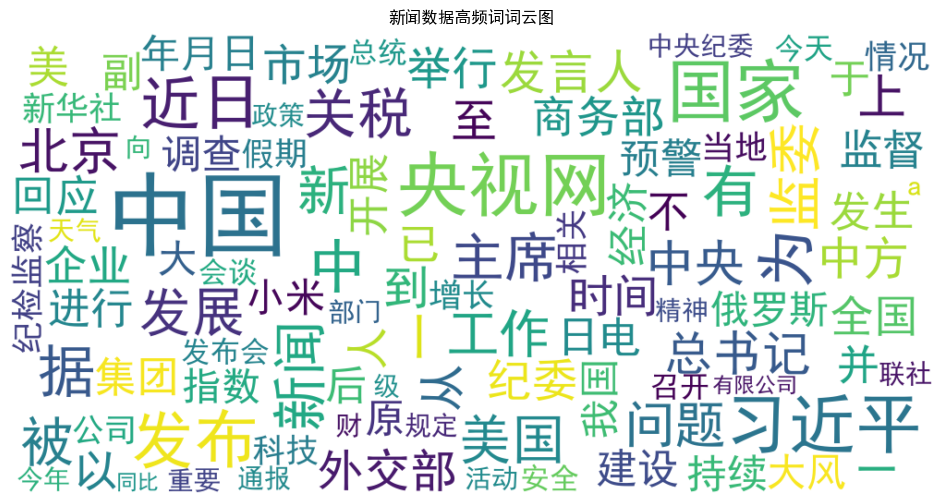

词云图已生成并显示。


In [21]:
print("\n--- 开始词频分析与关键词提取 ---")

if 'processed_words_list_stopwords_removed' in df.columns:
    # 1. 合并所有文本的词语列表 (已去停用词和短词)
    all_words = []
    for word_list in df['processed_words_list_stopwords_removed']:
        all_words.extend(word_list)
    # 2. 计算词频
    if all_words:
        word_counts = Counter(all_words)
    # 3. 获取最高频的 N 个词
        top_n = 50
        most_common_words = word_counts.most_common(top_n)
        print(f"\n全数据集 Top {top_n} 关键词及其频率:")
        for word, count in most_common_words:
            print(f"{word}: {count}")
     # 4. 生成词云图
        print("\n正在生成词云图...")
        try:
            # 注意：确保你的环境中有支持中文的字体文件，并替换下面的 'path/to/your/chinese_font.ttf'
            # 在 Colab 中，可以上传字体文件或使用 Colab 自带的，例如 '/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc'
            # 在 Windows 中，可能是 'C:/Windows/Fonts/simhei.ttf' 等
            # font_path = '/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc' # 示例 Colab 路径
            # font_path = 'simhei.ttf' # 如果你上传了 SimHei 字体
            font_path = 'C:/Windows/Fonts/simhei.ttf' # 示例 Windows 路径 (如果安装了 SimHei)

            # 检查字体路径是否存在 (可选但推荐)
            # import os
            # if not os.path.exists(font_path):
                 # print(f"警告：字体文件 '{font_path}' 不存在，词云可能无法正确显示中文。请指定正确的字体路径。")
                 # 可以尝试找一个系统默认字体，但这不保证支持中文
                 # font_path = None # 使用WordCloud默认字体，可能不支持中文

            wordcloud = WordCloud(
                font_path=font_path,       # 指定默认字体
                width=1000,                # 设置宽度
                height=500,                # 设置高度
                background_color='white',  # 设置背景颜色
                max_words=100,             # 最多显示词数
                max_font_size=100,         # 最大字号
                collocations=False         # 避免生成组合词
            ).generate_from_frequencies(word_counts) # 从词频字典生成
                # 在生成文本或数据处理时，禁止或避免创建组合词。
                # 组合词是指由两个或多个词组合在一起形成的新词，具有特定的意义。
                # 设置"collocations"为"False"，可以确保在生成内容时，各个词语保持独立，不会自动结合成新的词汇，从而保持原文的词义清晰和准确。
                # 这种设置通常用于自然语言处理、文本生成或数据分析等领域，以控制输出结果的准确性和可读性。
            # 显示词云图
            plt.figure(figsize=(12, 6))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off') # 不显示坐标轴
            plt.title('新闻数据高频词词云图')
            plt.savefig('wordcloud_all_news.png') # 保存图像
            plt.show()
            print("词云图已生成并显示。")

        except Exception as e:
            print(f"生成词云图失败: {e}")
            print("请确保已安装 wordcloud 库，并提供了正确的、支持中文的字体文件路径。")

    else:
        print("没有有效的词语进行词频分析。")
else:
    print("错误：'processed_words_list_stopwords_removed' 列不存在，无法进行词频分析。")

#### 第4步：情感分析 (Sentiment Analysis) - Hugging Face

- 操作: 选择一个合适的**中文情感分析模型**，使用`Hugging Face pipeline`对新闻文本（例如 `processed_text_str` 列）进行情感分类（积极/消极），并提取**情感得分**作为强度参考。
- **原因与依据**:
    - **核心需求**: 情感分析是理解文本态度的关键方法，也是LLM的强项。
    - **Hugging Face Pipeline**: 这是**使用预训练模型**最便捷的方式，封装了复杂的*Tokenization和模型推理*过程，对入门者友好。
    - **模型选择**: `uer/roberta-base-finetuned-dianping-chinese` 是一个广泛使用且效果不错的中文情感模型，训练自大众点评数据集，适合快速上手。注释中也提供了寻找其他模型的线索。
    - **GPU/CPU自动选择**: 代码 `device=0 if torch.cuda.is_available() else -1` 能自动利用可用的GPU加速计算，或在没有GPU时使用CPU。
    -**处理细节**:
        - 函数化 (analyze_sentiment) 使代码清晰。
        - 处理空值 (isinstance, pd.isna) 保证代码健壮性。
        - 明确截断 (truncation=True) 防止超长文本导致模型出错，并告知用户这一行为。
        - 统一标签，方便后续统计。
        - 错误处理 (try-except) 能捕获分析过程中的异常，避免程序中断。
    - **结果展示:**
        - .head() 预览结果。
        - value_counts() 统计分布。
        - countplot 可视化分布，直观易懂。
        - 计算**平均得分**，提供一个整体情感度量。
        - **时间趋势图（如果时间列可用）** 展示情感随时间的变化，是很有价值的分析维度。

完整代码示例，包括了错误排除，接下来将分步骤进行
```
print("\n--- 开始情感分析 ---")

# 检查必要的列是否存在
if 'processed_text_str' not in df.columns:
    print("错误：'processed_text_str' 列不存在，无法进行情感分析。请先执行预处理步骤。")
else:
    # 1. 选择并加载预训练模型
    # 你可以在 Hugging Face Hub 搜索更多模型: https://huggingface.co/models?pipeline_tag=text-classification&language=zh&sort=downloads
    # 备选模型：
    # 'uer/roberta-base-finetuned-dianping-chinese' (基于点评数据，通用性较好)
    # 'hfl/chinese-roberta-wwm-ext-large' (强大的基础模型，但需要找情感微调版本)
    # 'uer/chinese_roberta_L-12_H-768_A-12' (另一个BERT类模型)
    # 我们选择一个相对轻量且常用的
    model_name = "uer/roberta-base-finetuned-chinanews-chinese"
    # 我们选取中国新闻网训练的模型
    try:
        print(f"正在加载情感分析模型: {model_name} ...")
        # 使用 pipeline 简化调用，自动处理Tokenization和推理
        # device=0 表示使用GPU (如果可用)， device=-1 表示使用CPU
        sentiment_analyzer = pipeline(
            "sentiment-analysis",
            model=model_name,
            tokenizer=model_name, # 通常模型和tokenizer同名
            device=0 if torch.cuda.is_available() else -1 # 自动选择GPU或CPU
        )
        print("情感分析模型加载成功。")

        # 2. 定义情感分析函数 (处理pipeline输出)
        def analyze_sentiment(text):
            """对单条文本进行情感分析，返回标签和分数"""
            # 处理空文本或NaN值
            if not isinstance(text, str) or pd.isna(text) or len(text.strip()) == 0:
                return 'unknown', 0.0 # 或者返回 None, None

            try:
                # pipeline 返回一个列表，通常只包含一个结果字典
                # 注意：模型输入有长度限制 (通常512 tokens)，过长文本会被截断
                # 这意味着在处理文本数据时，模型能够接受的最大字符数或词汇单元数量被限定在512个以内。
                # 这一限制是为了确保模型在计算和处理时能够保持高效和稳定，避免因输入过长而导致性能下降或无法处理的问题。
                # 在实际应用中，如果输入文本超过这一限制，通常需要对其进行截断或分批处理。
                result = sentiment_analyzer(text, truncation=True, max_length=512) # 明确截断
                
                label = result[0]['label']
                score = result[0]['score']

                # 统一标签 (不同模型可能输出 'positive'/'negative' 或 'LABEL_1'/'LABEL_0')
                if label.lower() == 'positive' or label == 'LABEL_1':
                    sentiment = 'positive'
                elif label.lower() == 'negative' or label == 'LABEL_0':
                    sentiment = 'negative'
                else:
                    sentiment = 'neutral' # 或 'unknown'，取决于模型能力和你的设定,在哪里看？
                return sentiment, score
            except Exception as e:
                # print(f"情感分析时发生错误: {e}，文本: '{text[:50]}...'") # 调试时打印错误
                return 'error', 0.0 # 标记错误

        # 3. 将情感分析应用到DataFrame (这可能需要较长时间，取决于数据量和硬件)
        print("正在对新闻文本进行情感分析 (可能需要几分钟到几小时)...")
        tqdm.pandas(desc="Applying Sentiment Analysis")
        # 应用函数，并将返回的元组拆分到两列
        df[['sentiment_label', 'sentiment_score']] = df['processed_text_str'].progress_apply(
            lambda x: pd.Series(analyze_sentiment(x))
        )

        print("\n情感分析完成。结果已添加到DataFrame。")

        # 4. 查看结果
        print("\n情感分析结果预览:")
        print(df[['processed_text_str', 'sentiment_label', 'sentiment_score']].head())

        print("\n情感标签分布统计:")
        print(df['sentiment_label'].value_counts())

        # 5. 可视化情感分布
        plt.figure(figsize=(8, 5))
        sns.countplot(data=df, x='sentiment_label', order=['positive', 'negative', 'neutral', 'unknown', 'error']) # 指定顺序
        plt.title('新闻情感标签分布')
        plt.xlabel('情感标签')
        plt.ylabel('数量')
        plt.savefig('sentiment_distribution.png')
        plt.show()

        # 6. 查看平均情感得分 (可以按时间或其他维度分组)
        # 注意：这里简单计算，positive=1, negative=-1, 其他=0
        sentiment_score_map = {'positive': 1, 'negative': -1, 'neutral': 0, 'unknown': 0, 'error': 0}
        df['sentiment_numeric'] = df['sentiment_label'].map(sentiment_score_map)
        average_sentiment = df['sentiment_numeric'].mean()
        print(f"\n数据集的平均情感得分（正1/负-1/中0）: {average_sentiment:.4f}")

        # (可选) 按时间聚合情感趋势 (如果时间列处理成功)
        if 'time' in df.columns and pd.api.types.is_datetime64_any_dtype(df['time']):
            # 按天聚合情感均值
            daily_sentiment = df.set_index('time')['sentiment_numeric'].resample('D').mean()
            plt.figure(figsize=(15, 6))
            daily_sentiment.plot()
            plt.title('新闻每日平均情感得分趋势')
            plt.xlabel('日期')
            plt.ylabel('平均情感得分')
            plt.grid(True)
            plt.savefig('sentiment_trend_daily.png')
            plt.show()
        else:
            print("\n未能绘制情感趋势图，因为 'time' 列不是有效的日期时间格式。")

    except Exception as e:
        print(f"加载或运行情感分析模型时出错: {e}")
        print("请检查模型名称是否正确、网络连接是否正常、以及Hugging Face库是否安装完全。")
        ```

In [ ]:
model_name = "uer/roberta-base-finetuned-dianping-chinese"
    # 我们选取大众点评数据训练的模型
if torch.cuda.is_available():
    torch.cuda.empty_cache() # 尝试释放未被占用的缓存显存  
print(f"正在加载情感分析模型: {model_name} ...")
    # 使用 pipeline 简化调用，自动处理Tokenization和推理
    # device=0 表示使用GPU (如果可用)， device=-1 表示使用CPU
sentiment_analyzer = pipeline(
        "sentiment-analysis",
        model=model_name,
        tokenizer=model_name, # 通常模型和tokenizer同名
        device=0 if torch.cuda.is_available() else -1 # 自动选择GPU或CPU
        )
print("情感分析模型加载成功。")


正在加载情感分析模型: uer/roberta-base-finetuned-dianping-chinese ...



Device set to use cuda:0


情感分析模型加载成功。


In [23]:
from transformers import AutoConfig, AutoTokenizer, AutoModel

# 替换成你想查看的模型名称
model_name = "uer/roberta-base-finetuned-dianping-chinese" # 情感分析示例
# model_name = "clue/roberta_chinese_clue_ner" # NER 示例

# --- 查看模型配置 (config.json 的内容) ---
try:
    config = AutoConfig.from_pretrained(model_name)
    print("--- 模型配置 (Config) ---")
    # print(config) # 打印完整配置

    # 查找最大长度 (max_position_embeddings 通常最可靠)
    if hasattr(config, 'max_position_embeddings'):
        print(f"最大位置嵌入 (通常是最大长度): {config.max_position_embeddings}")
    if hasattr(config, 'model_max_length'):
        print(f"模型配置中的 model_max_length: {config.model_max_length}") # 注意这个不一定存在或准确

    # 查找标签映射 (对分类/NER模型)
    if hasattr(config, 'id2label'):
        print("ID 到标签 (id2label):")
        print(config.id2label)
    if hasattr(config, 'label2id'):
        print("标签到 ID (label2id):")
        print(config.label2id)
    if hasattr(config, 'num_labels'):
        print(f"标签数量: {config.num_labels}")

except Exception as e:
    print(f"加载或检查模型配置失败: {e}")

print("-" * 20)

# --- 查看分词器配置 ---
try:
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    print("--- 分词器配置 (Tokenizer) ---")
    # print(tokenizer) # 打印完整分词器信息

    # 查看分词器报告的最大长度 (可能与模型实际能力不同)
    print(f"分词器报告的最大长度 (tokenizer.model_max_length): {tokenizer.model_max_length}")

    # 查看特殊 tokens
    print(f"Pad token: {tokenizer.pad_token} (ID: {tokenizer.pad_token_id})")
    print(f"CLS token: {tokenizer.cls_token} (ID: {tokenizer.cls_token_id})") # BERT/RoBERTa 类
    print(f"SEP token: {tokenizer.sep_token} (ID: {tokenizer.sep_token_id})") # BERT/RoBERTa 类
    print(f"Unknown token: {tokenizer.unk_token} (ID: {tokenizer.unk_token_id})")

except Exception as e:
    print(f"加载或检查分词器失败: {e}")

--- 模型配置 (Config) ---
最大位置嵌入 (通常是最大长度): 512
ID 到标签 (id2label):
{0: 'negative (stars 1, 2 and 3)', 1: 'positive (stars 4 and 5)'}
标签到 ID (label2id):
{'negative (stars 1, 2 and 3)': 0, 'positive (stars 4 and 5)': 1}
标签数量: 2
--------------------
--- 分词器配置 (Tokenizer) ---
分词器报告的最大长度 (tokenizer.model_max_length): 1000000000000000019884624838656
Pad token: [PAD] (ID: 0)
CLS token: [CLS] (ID: 101)
SEP token: [SEP] (ID: 102)
Unknown token: [UNK] (ID: 100)


In [24]:
# 2. 定义情感分析函数 (处理pipeline输出)
def analyze_sentiment(text):
    """对单条文本进行情感分析，返回标签和分数"""
    # 处理空文本或NaN值
    if not isinstance(text, str) or pd.isna(text) or len(text.strip()) == 0:
        return 'unknown', 0.0 # 或者返回 None, None

            # pipeline 返回一个列表，通常只包含一个结果字典
            # 注意：模型输入有长度限制 (通常512 tokens)，过长文本会被截断
                # 这意味着在处理文本数据时，模型能够接受的最大字符数或词汇单元数量被限定在512个以内。
                # 这一限制是为了确保模型在计算和处理时能够保持高效和稳定，避免因输入过长而导致性能下降或无法处理的问题。
                # 在实际应用中，如果输入文本超过这一限制，通常需要对其进行截断或分批处理。
    result = sentiment_analyzer(text, truncation=True, max_length=512) # 明确截断
                
    label = result[0]['label']
    score = result[0]['score']

        # 统一标签 (不同模型可能输出 'positive'/'negative' 或 'LABEL_1'/'LABEL_0'，根据上面的调查我们可知，其输出为0: 'negative (stars 1, 2 and 3)', 1: 'positive (stars 4 and 5)')
    if label.lower() == 'positive (stars 4 and 5)' or label == 'LABEL_1':
        sentiment = 'positive'
    elif label.lower() == 'negative (stars 1, 2 and 3)' or label == 'LABEL_0':
        sentiment = 'negative'
    else:
        sentiment = 'neutral' # 或 'unknown'，取决于模型能力和你的设定,建议用代码查看（如上）
    return sentiment, score
    



In [25]:
# 3. 将情感分析应用到DataFrame (这可能需要较长时间，取决于数据量和硬件)
print("正在对新闻文本进行情感分析 (可能需要几分钟到几小时)...")
tqdm.pandas(desc="Applying Sentiment Analysis")
# 应用函数，并将返回的元组拆分到两列
df[['sentiment_label', 'sentiment_score']] = df['processed_text_str'].progress_apply(lambda x: pd.Series(analyze_sentiment(x)))

# 将数据框 df 中的 processed_text_str 列的文本数据逐行进行情感分析，并将分析结果分别存储在新的两列 sentiment_label 和 sentiment_score 中。
    # 具体来说，progress_apply 函数用于对 processed_text_str 列的每个元素（即每段文本）应用一个匿名函数（lambda函数），该匿名函数调用 analyze_sentiment 函数对文本进行情感分析。
    # analyze_sentiment 函数返回一个包含情感标签和情感分数的序列（pd.Series）
    # 然后这两个值分别赋值给 sentiment_label 和 sentiment_score 列。这样，每行文本的情感分析结果就被存储在了相应的列中。
print("\n情感分析完成。结果已添加到DataFrame。")

# 4. 查看结果
print("\n情感分析结果预览:")
print(df[['processed_text_str', 'sentiment_label', 'sentiment_score']].head())
print("\n情感标签分布统计:")
print(df['sentiment_label'].value_counts())



正在对新闻文本进行情感分析 (可能需要几分钟到几小时)...


Applying Sentiment Analysis:   0%|          | 0/3471 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



情感分析完成。结果已添加到DataFrame。

情感分析结果预览:
                                  processed_text_str sentiment_label  \
0  我们 不 惹事 也 不怕 事 来源 央视网 美国 对 全球 滥施 关税 的 余震 还 在 继...        negative   
1  海关总署 月 日 时分 起 执行 对 原产 于 美国 的 进口商品 加征 关税 海关总署 月...        negative   
2  北京市 气象台 发布 重要 天气 提示信息 受 冷涡 加强 东移 南下 影响 日 下午 至日...        positive   
3  极端 大风 强 降温 明天 上午 北京 将 提前 发布 大风 橙色 预警 信号 北京市 气象...        positive   
4  教育部 发布 年 第号 留学 预警 近日 美国 俄亥俄州 通过 有关 高等教育 法案 其中 ...        negative   

   sentiment_score  
0         0.585373  
1         0.975779  
2         0.820130  
3         0.601998  
4         0.967763  

情感标签分布统计:
sentiment_label
positive    2129
negative    1342
Name: count, dtype: int64


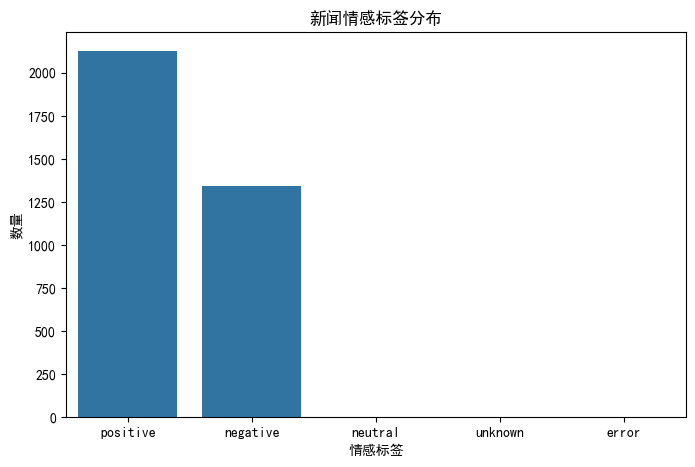

In [26]:
# 5. 可视化情感分布
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='sentiment_label', order=['positive', 'negative', 'neutral', 'unknown', 'error']) # 指定顺序
plt.title('新闻情感标签分布')
plt.xlabel('情感标签')
plt.ylabel('数量')
plt.savefig('sentiment_distribution.png')
plt.show()

In [27]:
# 6. 查看平均情感得分 (可以按时间或其他维度分组)
# 注意：这里简单计算，positive=1, negative=-1, 其他=0
sentiment_score_map = {'positive': 1, 'negative': -1, 'neutral': 0, 'unknown': 0, 'error': 0}
df['sentiment_numeric'] = df['sentiment_label'].map(sentiment_score_map)

average_sentiment = df['sentiment_numeric'].mean()
print(f"\n数据集的平均情感得分（正1/负-1/中0）: {average_sentiment:.4f}")


数据集的平均情感得分（正1/负-1/中0）: 0.2267


`df['sentiment_numeric'] = df['sentiment_label'].map(sentiment_score_map)`

使用`pandas`库对DataFrame对象进行操作。将`DataFrame df` 中的 ‘sentiment_label’ 列根据 `sentiment_score_map` 这个映射（字典）转换成数值，并将转换后的数值存储在新的列 ‘sentiment_numeric’ 中。

具体来说：
- df 是一个DataFrame，是pandas库中的基本数据结构，用于数据处理和分析。
- 'sentiment_label' 是DataFrame df 中的一个列名，这一列包含了情感标签，如正面、负面等分类标签。
- sentiment_score_map 是一个映射（字典），它将情感标签（键）映射到相应的数值分数（值）。
- map 函数是一个pandas方法，用于将 ‘sentiment_label’ 列中的每个标签替换为 sentiment_score_map 中对应的数值。
- 新创建的列 ‘sentiment_numeric’ 将包含转换后的数值分数。

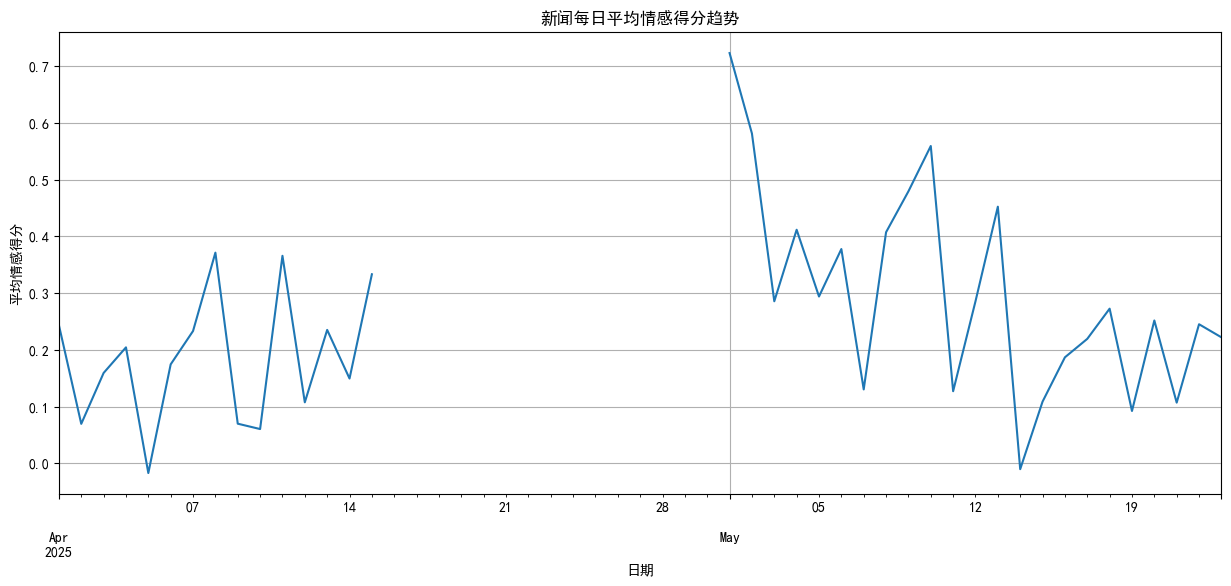

In [28]:
# (可选) 按时间聚合情感趋势 (如果时间列处理成功)
if 'timestamp' in df.columns and pd.api.types.is_datetime64_any_dtype(df['timestamp']):
    # 按天聚合情感均值
    daily_sentiment = df.set_index('timestamp')['sentiment_numeric'].resample('D').mean()
    plt.figure(figsize=(15, 6))
    daily_sentiment.plot()
    plt.title('新闻每日平均情感得分趋势')
    plt.xlabel('日期')
    plt.ylabel('平均情感得分')
    plt.grid(True)
    plt.savefig('sentiment_trend_daily.png')
    plt.show()
else:
    print("\n未能绘制情感趋势图，因为 'time' 列不是有效的日期时间格式。")

#### 第5步：命名实体识别 (NER) - Hugging Face
- 操作: 使用**NER模型**识别文本中的*人名（PER）、地名（LOC）、组织机构名（ORG）等实体*。

#### 示例代码如下
- **原因与依据**:
    - **信息提取**: NER是信息提取（IE）的基础任务，能自动从文本中找出*关键信息点（人、地、组织等*），有助于快速了解新闻涉及的核心对象。
    - **Hugging Face Pipeline**: 同样使用`pipeline`简化操作，`token-classification`是NER任务对应的pipeline类型。
    - **模型选择**: `clue/roberta_chinese_clue_ner` 是一个*基于RoBERTa的常用中文NER模型*，效果较好。
    - `aggregation_strategy="simple"`: 这个参数非常重要，它能**自动将属于同一个实体的、被模型分成多个token的部分（例如“北京”可能被分成“北”和“京”）合并起来**，输出更简洁、易用的结果。
    - 性能考虑: NER通常比简单情感分析更耗时，因此代码中**加入了对样本量(sample_size_ner)的控制**，允许你先在小数据集上测试流程，再决定是否处理全部数据。
    - **结果分析**: 不仅要提取实体，还要进行**统计分析（各类型数量、最常见实体词）**，并通过**可视化（条形图）**展示，使结果更清晰。

    - ！！！该流程只针对常见的SIO输出格式，像clue/roberta_chinese_clue_ner（未找到），可以实现`pipline`高级封装+`aggregation_strategy="simple"`简单的调用，直接使用模型和分词器进行预测如果是BIESO标注，如ckiplab/bert-base-chinese-ner，则需要手动解析模型的输出！！！

        - pipeline：在NLP中，pipeline指的是**一系列处理步骤的集合**，这些步骤按顺序执行，以完成特定的任务，如命名实体识别（NER）。

        - token-classification：这是pipeline中的一个流程，用于对文本中的**每个token（词语）进行分类**，常用于命名实体识别等任务。

        - BIESO：是一种标注方案，用于标记文本中的**实体边界和类别**。BIESO方案将实体边界分为开始（B）、内部（I）、外部（E）和单独（S）四种类型，而常见的BIO方案只分为开始（B）、内部（I）和单独（O）三种类型。

        - aggregation_strategy="simple"：这是在处理模型输出时使用的一种聚合策略，通常用于将模型的预测结果合并成最终输出。简单策略可能只是取所有token预测结果的众数。

        尽管设计了一个通用的pipeline，但并不是所有模型都能无缝地适应这个pipeline默认的token-classification流程。特别是当模型使用不同于常见的BIO标注方案的BIESO方案时，或者模型输出格式与默认的流程不匹配时。对于ckiplab/bert-base-chinese-ner这种特定模型，使用"simple"聚合策略可能无法正确处理模型的原始输出，导致预测结果不准确。
#### 1.针对简单SIO标注的NER模型
```python
print("\n--- 开始命名实体识别 (NER) ---")

if 'processed_text_str' not in df.columns:
    print("错误：'processed_text_str' 列不存在，无法进行NER。请先执行预处理步骤。")
else:
    # 1. 选择并加载中文NER模型
    # 可以在 Hugging Face Hub 搜索 'chinese', 'ner', 'token-classification'
    # 常用模型包括基于BERT或RoBERTa微调的模型
    ner_model_name = "clue/roberta_chinese_clue_ner" # 一个基于RoBERTa的常用中文NER模型
    try:
        print(f"正在加载NER模型: {ner_model_name} ...")
        # 使用 token-classification pipeline
        # aggregation_strategy="simple" 会将属于同一个实体的多个token合并
        ner_pipeline = pipeline(
            "token-classification",
            model=ner_model_name,
            tokenizer=ner_model_name,
            aggregation_strategy="simple", # 简化输出格式
            device=0 if torch.cuda.is_available() else -1
        )
        print("NER模型加载成功。")

        # 2. 定义NER应用函数
        def extract_entities(text):
            """对单条文本进行NER，返回实体列表"""
            if not isinstance(text, str) or pd.isna(text) or len(text.strip()) == 0:
                return []
            try:
                # 注意长度限制
                entities = ner_pipeline(text, truncation=True, max_length=512)
                # pipeline 返回 [{'entity_group': 'LOC', 'score': 0.99, 'word': '北京'}, ...]
                return entities
            except Exception as e:
                # print(f"NER时发生错误: {e}，文本: '{text[:50]}...'")
                return [{'entity_group': 'ERROR', 'word': 'Processing Error'}] # 返回错误标记

        # 3. 应用NER到DataFrame (同样可能耗时)
        # 为了演示，我们可能只对部分数据运行，例如前1000条
        sample_size_ner = 1000 # 可以调整这个值，或者设为 len(df) 处理全部
        print(f"正在对前 {min(sample_size_ner, len(df))} 条新闻文本进行NER...")
        tqdm.pandas(desc="Applying NER")
        df['entities'] = df['processed_text_str'].head(sample_size_ner).progress_apply(extract_entities)
        # 对剩余部分填充空列表或其他标记
        if sample_size_ner < len(df):
             df['entities'] = df['entities'].fillna(pd.Series([[] for _ in range(len(df))])) # 填充空列表

        print("\nNER完成。结果已添加到DataFrame (部分或全部)。")

        # 4. 分析提取出的实体
        print("\nNER结果预览 (前5条):")
        # 只显示非空结果
        print(df[df['entities'].apply(lambda x: len(x) > 0 and x[0]['entity_group'] != 'ERROR')][['processed_text_str', 'entities']].head())

        # 统计不同类型的实体数量
        all_entities = []
        # 仅从已处理的样本中提取
        for entity_list in df['entities'].dropna(): # dropna以防填充了NaN
            if isinstance(entity_list, list): # 确保是列表
                 all_entities.extend(entity_list)

        entity_counts = Counter(entity['entity_group'] for entity in all_entities if entity['entity_group'] != 'ERROR')

        if entity_counts:
            print("\n识别出的实体类型统计:")
            print(entity_counts)

            # 可视化实体类型分布
            plt.figure(figsize=(10, 6))
            sns.barplot(x=list(entity_counts.keys()), y=list(entity_counts.values()))
            plt.title('识别出的命名实体类型分布')
            plt.xlabel('实体类型')
            plt.ylabel('数量')
            plt.xticks(rotation=45, ha='right')
            plt.savefig('ner_entity_type_distribution.png')
            plt.show()

            # 找出最常见的几个实体词 (例如，最常出现的人名、地名)
            top_n_entities = 30
            entity_word_counts = Counter(entity['word'] for entity in all_entities if entity['entity_group'] != 'ERROR')
            print(f"\n最常见的 {top_n_entities} 个实体词:")
            print(entity_word_counts.most_common(top_n_entities))
        else:
            print("\n未能从样本中提取到有效实体。")
    except Exception as e:
        print(f"加载或运行NER模型时出错: {e}")
    ```
    

### 针对复杂的BIESO标注的NER模型
我们需要绕过 `pipeline` 的高级封装，直接使用模型和分词器进行预测，然后手动解析模型的输出，并根据其标注方案（BIESO）来组合实体。
**BIESO 标注方案解释**:
- B (Begin): 实体开始的 Token。
- I (Inside): 实体内部的 Token。
- E (End): 实体结束的 Token。
- S (Single): 单个 Token 构成的实体。
- O (Outside): 非实体部分。

In [29]:

print("\n--- 开始命名实体识别 (NER) ---")

    # 1. 选择并加载中文NER模型
    # 可以在 Hugging Face Hub 搜索 'chinese', 'ner', 'token-classification'
    # 常用模型包括基于BERT或RoBERTa微调的模型
ner_model_name = "ckiplab/bert-base-chinese-ner" # 一个基于RoBERTa的常用中文NER模型

print(f"正在加载NER模型: {ner_model_name} ...")

# 放弃使用 token-classification pipeline(aggregation_strategy="simple")，使用AutoTokenizer加载分词器并手动调试
tokenizer = AutoTokenizer.from_pretrained(ner_model_name)
 # 加载模型 (用于Token分类)
model = AutoModelForTokenClassification.from_pretrained(ner_model_name)

# 检查是否有GPU可用，并将模型移动到GPU
if torch.cuda.is_available():
    device = torch.device("cuda:0") # 使用第一个GPU
    model.to(device)
    print("模型已移动到 GPU。")
else:
    device = torch.device("cpu")
    print("模型将在 CPU 上运行。")

print("NER模型和分词器加载成功。")




--- 开始命名实体识别 (NER) ---
正在加载NER模型: ckiplab/bert-base-chinese-ner ...
模型已移动到 GPU。
NER模型和分词器加载成功。


In [30]:
from transformers import AutoConfig, AutoTokenizer, AutoModel

# 替换成你想查看的模型名称
model_name = "ckiplab/bert-base-chinese-ner" # 情感分析示例
# model_name = "clue/roberta_chinese_clue_ner" # NER 示例

# --- 查看模型配置 (config.json 的内容) ---
try:
    config = AutoConfig.from_pretrained(model_name)
    print("--- 模型配置 (Config) ---")
    # print(config) # 打印完整配置

    # 查找最大长度 (max_position_embeddings 通常最可靠)
    if hasattr(config, 'max_position_embeddings'):
        print(f"最大位置嵌入 (通常是最大长度): {config.max_position_embeddings}")
    if hasattr(config, 'model_max_length'):
        print(f"模型配置中的 model_max_length: {config.model_max_length}") # 注意这个不一定存在或准确

    # 查找标签映射 (对分类/NER模型)
    if hasattr(config, 'id2label'):
        print("ID 到标签 (id2label):")
        print(config.id2label)
    if hasattr(config, 'label2id'):
        print("标签到 ID (label2id):")
        print(config.label2id)
    if hasattr(config, 'num_labels'):
        print(f"标签数量: {config.num_labels}")

except Exception as e:
    print(f"加载或检查模型配置失败: {e}")

print("-" * 20)

# --- 查看分词器配置 ---
try:
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    print("--- 分词器配置 (Tokenizer) ---")
    # print(tokenizer) # 打印完整分词器信息

    # 查看分词器报告的最大长度 (可能与模型实际能力不同)
    print(f"分词器报告的最大长度 (tokenizer.model_max_length): {tokenizer.model_max_length}")

    # 查看特殊 tokens
    print(f"Pad token: {tokenizer.pad_token} (ID: {tokenizer.pad_token_id})")
    print(f"CLS token: {tokenizer.cls_token} (ID: {tokenizer.cls_token_id})") # BERT/RoBERTa 类
    print(f"SEP token: {tokenizer.sep_token} (ID: {tokenizer.sep_token_id})") # BERT/RoBERTa 类
    print(f"Unknown token: {tokenizer.unk_token} (ID: {tokenizer.unk_token_id})")

except Exception as e:
    print(f"加载或检查分词器失败: {e}")

--- 模型配置 (Config) ---
最大位置嵌入 (通常是最大长度): 512
ID 到标签 (id2label):
{0: 'O', 1: 'B-CARDINAL', 2: 'B-DATE', 3: 'B-EVENT', 4: 'B-FAC', 5: 'B-GPE', 6: 'B-LANGUAGE', 7: 'B-LAW', 8: 'B-LOC', 9: 'B-MONEY', 10: 'B-NORP', 11: 'B-ORDINAL', 12: 'B-ORG', 13: 'B-PERCENT', 14: 'B-PERSON', 15: 'B-PRODUCT', 16: 'B-QUANTITY', 17: 'B-TIME', 18: 'B-WORK_OF_ART', 19: 'I-CARDINAL', 20: 'I-DATE', 21: 'I-EVENT', 22: 'I-FAC', 23: 'I-GPE', 24: 'I-LANGUAGE', 25: 'I-LAW', 26: 'I-LOC', 27: 'I-MONEY', 28: 'I-NORP', 29: 'I-ORDINAL', 30: 'I-ORG', 31: 'I-PERCENT', 32: 'I-PERSON', 33: 'I-PRODUCT', 34: 'I-QUANTITY', 35: 'I-TIME', 36: 'I-WORK_OF_ART', 37: 'E-CARDINAL', 38: 'E-DATE', 39: 'E-EVENT', 40: 'E-FAC', 41: 'E-GPE', 42: 'E-LANGUAGE', 43: 'E-LAW', 44: 'E-LOC', 45: 'E-MONEY', 46: 'E-NORP', 47: 'E-ORDINAL', 48: 'E-ORG', 49: 'E-PERCENT', 50: 'E-PERSON', 51: 'E-PRODUCT', 52: 'E-QUANTITY', 53: 'E-TIME', 54: 'E-WORK_OF_ART', 55: 'S-CARDINAL', 56: 'S-DATE', 57: 'S-EVENT', 58: 'S-FAC', 59: 'S-GPE', 60: 'S-LANGUAGE', 61: 'S-LA

In [ ]:
# 2. 定义手动 NER 函数 (核心修改)
def extract_entities_manual(text):
            """手动对单条文本进行NER，解析BIESO标签"""
            if not isinstance(text, str) or pd.isna(text) or len(text.strip()) == 0:
                return []

            try:
                # --- 手动进行 Tokenization 和模型预测 ---
                # 使用分词器处理文本，获取 input_ids, attention_mask 等
                # return_offsets_mapping=True 用于获取每个token对应的原始文本位置
                inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, return_offsets_mapping=True)
                offset_mapping = inputs.pop("offset_mapping").squeeze().tolist() # 获取 offset mapping 并移除，因为它不输入模型

                # 将输入数据移动到模型所在的设备 (GPU或CPU)
                inputs = {k: v.to(device) for k, v in inputs.items()}

                # 不计算梯度，节省显存和计算量
                with torch.no_grad():
                    outputs = model(**inputs)

                # 获取模型预测的每个token的类别概率，并找到概率最大的类别ID
                predictions = torch.argmax(outputs.logits, dim=2)
                predictions = predictions.squeeze().tolist() # 转换成列表

                # 获取模型配置中的 id2label 映射
                id2label = model.config.id2label

                # --- 解析 BIESO 标签，组合实体 ---
                entities = []
                current_entity_tokens = []
                current_entity_type = None
                start_offset, end_offset = -1, -1

                # 迭代处理每个 token 的预测结果
                # 跳过特殊token [CLS] 和 [SEP] (通常是第一个和最后一个)
                for i, pred_id in enumerate(predictions[1:-1]): # 忽略 CLS 和 SEP
                    label = id2label[pred_id]
                    # 获取当前 token 在原始文本中的起止位置
                    token_start, token_end = offset_mapping[i+1] # i+1 因为 offset_mapping 包含 CLS

                    # 如果当前 token 是非实体(O) 或 遇到新实体的开始 (B 或 S)
                    if label == 'O' or label.startswith('B-') or label.startswith('S-'):
                        # 如果之前正在追踪一个实体，现在结束了，就保存它
                        if current_entity_type:
                            entity_word = text[start_offset:end_offset]
                            entities.append({
                                'entity_group': current_entity_type,
                                'word': entity_word,
                                'start': start_offset,
                                'end': end_offset
                                # 可以添加 'score'，但需要更复杂的处理 logits
                            })
                            current_entity_tokens = []
                            current_entity_type = None
                            start_offset, end_offset = -1, -1

                        # 如果是新实体的开始 (B)
                        if label.startswith('B-'):
                            current_entity_type = label[2:] # 获取实体类型，如 PERSON
                            current_entity_tokens.append(text[token_start:token_end])
                            start_offset = token_start
                            end_offset = token_end # 暂时设为当前token结束位置
                        # 如果是单个token的实体 (S)
                        elif label.startswith('S-'):
                            entity_type = label[2:]
                            entity_word = text[token_start:token_end]
                            entities.append({
                                'entity_group': entity_type,
                                'word': entity_word,
                                'start': token_start,
                                'end': token_end
                            })
                            # 重置状态
                            current_entity_tokens = []
                            current_entity_type = None
                            start_offset, end_offset = -1, -1
                        # 如果是 O，则什么都不做，继续下一个token

                    # 如果是实体内部 (I) 或 实体结束 (E)
                    elif label.startswith('I-') or label.startswith('E-'):
                        # 必须在已开始追踪实体的情况下才有效
                        if current_entity_type:
                            # 检查实体类型是否匹配 (I/E 标签应与 B 标签类型一致)
                            if label[2:] == current_entity_type:
                                current_entity_tokens.append(text[token_start:token_end])
                                end_offset = token_end # 更新结束位置
                                # 如果是 E 标签，实体结束，保存
                                if label.startswith('E-'):
                                    entity_word = text[start_offset:end_offset]
                                    entities.append({
                                        'entity_group': current_entity_type,
                                        'word': entity_word,
                                        'start': start_offset,
                                        'end': end_offset
                                    })
                                    # 重置状态
                                    current_entity_tokens = []
                                    current_entity_type = None
                                    start_offset, end_offset = -1, -1
                            else:
                                # 类型不匹配，可能是一个标注错误或边界情况，先结束之前的实体
                                entity_word = text[start_offset:end_offset]
                                entities.append({
                                    'entity_group': current_entity_type,
                                    'word': entity_word,
                                    'start': start_offset,
                                    'end': end_offset
                                })
                                # 重置状态
                                current_entity_tokens = []
                                current_entity_type = None
                                start_offset, end_offset = -1, -1
                                # 这里可以考虑是否将当前I/E作为新实体的开始，但简单起见先忽略
                        else:
                            # 孤立的 I 或 E 标签，忽略或作为 O 处理
                            pass

                # 循环结束后，如果还在追踪实体（例如文本以B或I结尾），需要保存
                if current_entity_type:
                    entity_word = text[start_offset:end_offset]
                    entities.append({
                        'entity_group': current_entity_type,
                        'word': entity_word,
                        'start': start_offset,
                        'end': end_offset
                    })

                return entities

            except Exception as e:
                # print(f"手动NER时发生错误: {e}，文本: '{text[:50]}...'") # 调试用
                return [{'entity_group': 'ERROR', 'word': 'Manual Processing Error'}]

        


In [ ]:
# # 在SIO情况下应用NER到DataFrame (同样可能耗时)
# # 为了演示，我们可能只对部分数据运行，例如前1000条
# sample_size_ner = 1000 # 可以调整这个值，或者设为 len(df) 处理全部
# print(f"正在对前 {min(sample_size_ner, len(df))} 条新闻文本进行NER...")
# tqdm.pandas(desc="Applying NER")
# df['entities'] = df['processed_text_str'].head(sample_size_ner).progress_apply(extract_entities)
# # 对剩余部分填充空列表或其他标记
# if sample_size_ner < len(df):
#     df['entities'] = df['entities'].fillna(pd.Series([[] for _ in range(len(df))])) # 填充空列表

print("\nNER完成。结果已添加到DataFrame (部分或全部)。")
# 3. 应用手动NER函数到DataFrame
# 同样可以先对小样本进行测试
sample_size_ner = 1000
print(f"正在对前 {min(sample_size_ner, len(df))} 条新闻文本进行手动NER...")
tqdm.pandas(desc="Applying Manual NER")
if torch.cuda.is_available():
    torch.cuda.empty_cache() # 尝试释放未被占用的缓存显存
# 注意这里我们使用原始文本 df['text'] 或 df['full_text'] 可能更好，因为需要offset_mapping
# 如果使用 processed_text_str，offset可能不准
target_text_column = 'full_text' if 'full_text' in df.columns else 'headline' # 选择包含较完整信息的列
df['entities'] = df[target_text_column].head(sample_size_ner).progress_apply(extract_entities_manual)

if sample_size_ner < len(df):
    df['entities'] = df['entities'].fillna(pd.Series([[] for _ in range(len(df))]))

    print("\n手动NER完成。")


NER完成。结果已添加到DataFrame (部分或全部)。
正在对前 1000 条新闻文本进行手动NER...


Applying Manual NER:   0%|          | 0/1000 [00:00<?, ?it/s]


手动NER完成。



--- NER 结果分析 ---

诊断信息：'entities' 列值类型分布 (Top 10):
entities
<class 'list'>    3471
Name: count, dtype: int64

诊断信息：'entities' 列空列表/错误标记列表统计:
空列表 '[]' 的数量: 2489
仅含错误标记列表的数量: 0

NER结果预览 (前5条包含有效实体的结果):
                                           full_text  \
0  我们不惹事，也不怕事 来源：央视网 美国对全球滥施关税的“余震”还在继续，全球经济遭遇“黑色...   
1  海关总署：4月10日12时01分起，执行对原产于美国的进口商品加征84%关税 海关总署4月9...   
2  北京市气象台发布重要天气提示信息 受冷涡加强东移南下影响，11日下午至13日我市将出现一次极...   
3  极端大风➕强降温！明天上午北京将提前发布大风橙色预警信号 北京市气象台9日夜间介绍，受冷涡加...   
4  教育部发布2025年第1号留学预警 近日，美国俄亥俄州通过有关高等教育法案，其中包含涉华消极...   

                                            entities  
0  [{'entity_group': 'ORG', 'word': '央视网', 'start...  
1  [{'entity_group': 'ORG', 'word': '海关总署', 'star...  
2  [{'entity_group': 'ORG', 'word': '北京市气象台', 'st...  
3  [{'entity_group': 'TIME', 'word': '明天上午', 'sta...  
4  [{'entity_group': 'ORG', 'word': '教育部', 'start...  

识别出的有效实体类型统计:
Counter({'ORG': 1968, 'GPE': 1859, 'DATE': 1144, 'PERSON': 744, 'CARDINAL': 727, 'PERCENT': 234, 'TIME': 190, 'LOC': 

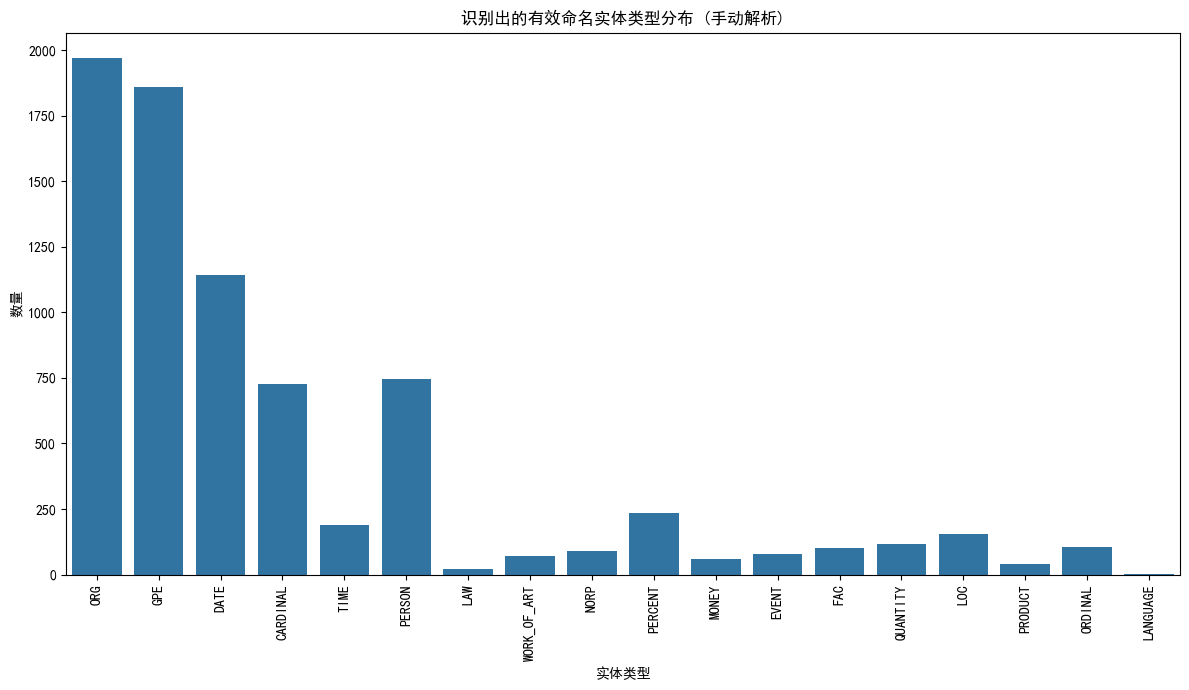


最常见的 30 个有效实体词:
[('中国', 267), ('美国', 160), ('美', 113), ('央视网', 96), ('商务部', 92), ('一', 85), ('外交部', 85), ('习近平', 76), ('三', 69), ('2025年', 65), ('中', 64), ('中方', 61), ('4月2日', 60), ('4月9日', 55), ('央视', 54), ('4月1日', 54), ('华', 51), ('美方', 51), ('北京', 49), ('4月3日', 45), ('两', 43), ('4月7日', 42), ('清明节', 38), ('江苏', 35), ('今天', 34), ('财联社', 32), ('台岛', 30), ('4月8日', 29), ('3', 29), ('4月4日', 28)]


In [33]:
# # 4. 分析提取出的实体
# print("\nNER结果预览 (前5条):")
# # 只显示非空结果
# print(df[df['entities'].apply(lambda x: len(x) > 0 and x[0]['entity_group'] != 'ERROR')][['processed_text_str', 'entities']].head())

# # 统计不同类型的实体数量
# all_entities = []
# # 仅从已处理的样本中提取
# for entity_list in df['entities'].dropna(): # dropna以防填充了NaN
#     if isinstance(entity_list, list): # 确保是列表
#         all_entities.extend(entity_list)

# entity_counts = Counter(entity['entity_group'] for entity in all_entities if entity['entity_group'] != 'ERROR')

# if entity_counts:
#             print("\n识别出的实体类型统计:")
#             print(entity_counts)

#             # 可视化实体类型分布
#             plt.figure(figsize=(10, 6))
#             sns.barplot(x=list(entity_counts.keys()), y=list(entity_counts.values()))
#             plt.title('识别出的命名实体类型分布')
#             plt.xlabel('实体类型')
#             plt.ylabel('数量')
#             plt.xticks(rotation=45, ha='right')
#             plt.savefig('ner_entity_type_distribution.png')
#             plt.show()

#             # 找出最常见的几个实体词 (例如，最常出现的人名、地名)
#             top_n_entities = 30
#             entity_word_counts = Counter(entity['word'] for entity in all_entities if entity['entity_group'] != 'ERROR')
#             print(f"\n最常见的 {top_n_entities} 个实体词:")
#             print(entity_word_counts.most_common(top_n_entities))
# else:
#             print("\n未能从样本中提取到有效实体。")

# 4. 分析提取出的实体 (修改筛选逻辑和增加诊断)
print("\n--- NER 结果分析 ---")

# --- 诊断步骤 1：查看 entities 列的非空值类型和数量 ---
print("\n诊断信息：'entities' 列值类型分布 (Top 10):")
# 使用 apply(type) 来查看每个单元格的实际类型
print(df['entities'].apply(type).value_counts().head(10))

print("\n诊断信息：'entities' 列空列表/错误标记列表统计:")
empty_list_count = df['entities'].apply(lambda x: x == []).sum()
error_list_count = df['entities'].apply(lambda x: x == [{'entity_group': 'ERROR', 'word': 'Manual Processing Error'}]).sum()
print(f"空列表 '[]' 的数量: {empty_list_count}")
print(f"仅含错误标记列表的数量: {error_list_count}")


# --- 修改预览代码的筛选逻辑 ---
print("\nNER结果预览 (前5条包含有效实体的结果):")

# 新的筛选逻辑：检查是否是列表，且列表中至少包含一个非 ERROR 的实体字典
def has_valid_entity(entity_list):
    if not isinstance(entity_list, list) or not entity_list: # 不是列表或是空列表
        return False
    # 检查是否只包含错误标记
    if entity_list == [{'entity_group': 'ERROR', 'word': 'Manual Processing Error'}]:
        return False
    # 检查是否至少有一个非ERROR实体 (更严格的检查)
    # for entity in entity_list:
    #    if isinstance(entity, dict) and entity.get('entity_group') != 'ERROR':
    #        return True
    # return False
    # 或者，只要不是上面两种情况（空列表或纯错误标记），就认为可能包含有效信息
    return True

valid_entities_mask = df['entities'].apply(has_valid_entity)
valid_entities_df = df[valid_entities_mask]

if not valid_entities_df.empty:
    # 使用原始 full_text 列查看可能更直观
    print(valid_entities_df[['full_text', 'entities']].head())
else:
    # 如果这里仍然为空，结合上面的诊断信息判断原因
    print("筛选后未能找到包含有效实体的样本行。请检查诊断信息。")
    if empty_list_count + error_list_count == len(df[df['entities'].notna()]):
            print("原因：所有非空 'entities' 单元格均为 空列表 或 错误标记列表。")
    else:
            print("原因：可能是筛选逻辑仍有问题，或 'extract_entities_manual' 函数未能成功提取有效实体。")


# --- 统计分析代码 (基本不变，但增加有效性检查) ---
all_entities = []
# 仅从已处理的样本中提取
for entity_list in df['entities'].dropna():
    # 再次确认是列表且非空
    if isinstance(entity_list, list) and entity_list:
            # 过滤掉错误标记实体
            valid_ones = [entity for entity in entity_list if isinstance(entity, dict) and entity.get('entity_group') != 'ERROR']
            all_entities.extend(valid_ones) # 只添加有效实体

if all_entities: # 确保 all_entities 列表不为空
    entity_counts = Counter(entity['entity_group'] for entity in all_entities) # entity_group 肯定不是 ERROR 了

    if entity_counts:
        print("\n识别出的有效实体类型统计:")
        print(entity_counts)

        # 可视化实体类型分布
        plt.figure(figsize=(12, 7))
        sns.barplot(x=list(entity_counts.keys()), y=list(entity_counts.values()))
        plt.title('识别出的有效命名实体类型分布 (手动解析)')
        plt.xlabel('实体类型')
        plt.ylabel('数量')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.savefig('ner_entity_type_distribution_manual_valid.png')
        plt.show()

        # 找出最常见的几个实体词
        top_n_entities = 30
        # 只统计来自有效实体列表的词
        entity_word_counts = Counter(entity['word'] for entity in all_entities)
        print(f"\n最常见的 {top_n_entities} 个有效实体词:")
        print(entity_word_counts.most_common(top_n_entities))
    else:
        # 这不应该发生，除非所有实体都被标记为ERROR（已经被过滤）
        print("\n所有提取到的实体都被标记为ERROR，无法统计有效实体类型。")

else:
        print("\n未能从样本中提取到任何有效实体（非错误标记）。请检查NER函数或输入数据。")

#### 第6步：主题建模 (Topic Modeling) - LDA
- **操作**: 使用`gensim`库实现`LDA（Latent Dirichlet Allocation）`模型，从*未标记的新闻数据*中**自动发现隐藏的主题**。
- **原因与依据**:
    - **发现潜在结构**: LDA是一种**无监督学习方法**，可以在*没有预先标签*的情况下，自动从大量文档中发现反复出现的主题模式。对于你未分类的新闻数据，这是一种有效的探索性分析方法。
    - **Gensim库**: 这是Python中进行**主题建模最常用和最强大的库之一**，提供了LDA的高效实现。
        - **标准流程**: 代码遵循了LDA的**标准流程**：
        - **准备文档**: 使用**分词后、去除停用词的词列表**。
        - **创建词典**: 映射词语到ID。`filter_extremes`有助于去除噪音（**太罕见或太普遍的词**）。
        - **创建语料库 (BoW)**: 将文档转换为模型可处理的向量格式。
        - **训练模型**: 使用`LdaModel`进行训练。`num_topics, passes` 等是重要参数。设置`random_state`保证结果可复现。
        - **解释主题**: `print_topics`显示**每个主题下概率最高的词**，这是理解主题内容的关键。**需要人工阅读这些词来归纳主题的含义**。
    - **模型评估 (可选但推荐)**: *主题一致性得分 (`CoherenceModel`, `c_v`)* 提供了一个**量化指标来评估主题质量**，分数越高通常表示主题内部的词语关联性越强，主题越清晰、可解释。这有助于选择合适的主题数。
    - **超参数调整**: 明确指出`num_topics`需要调整，并给出了通过计算一致性得分来寻找最优主题数的方法思路，这是LDA实践中的关键一步
- **代码**:
```python
print("\n--- 开始主题建模 (LDA) ---")

if 'processed_words_list_stopwords_removed' not in df.columns:
    print("错误：'processed_words_list_stopwords_removed' 列不存在，无法进行主题建模。")
else:
    # 1. 准备语料 (使用去除了停用词的词列表)
    documents = df['processed_words_list_stopwords_removed'].tolist()
    # 过滤掉空文档，LDA需要非空输入
    documents = [doc for doc in documents if doc]

    if len(documents) < 10: # 数据量太少可能无法有效建模
        print(f"警告：有效文档数量 ({len(documents)}) 过少，可能无法进行有意义的主题建模。")
    else:
        print(f"用于LDA的文档数量: {len(documents)}")
        try:
            # 2. 创建词典 (Dictionary)
            # 词典将每个词映射到一个唯一的ID
            dictionary = corpora.Dictionary(documents)
            print(f"词典大小 (唯一词数量): {len(dictionary)}")

            # 可选：过滤词典，移除出现次数过少或过多的词
            # no_below: 词语最少出现在no_below个文档中
            # no_above: 词语最多出现在no_above比例的文档中 (例如0.5表示超过一半文档都出现的词)
            dictionary.filter_extremes(no_below=5, no_above=0.6)
            print(f"过滤后词典大小: {len(dictionary)}")

            # 3. 创建语料库 (Corpus) - 词袋模型 (Bag-of-Words)
            # 将每个文档转换为 (词ID, 词频) 的稀疏向量
            corpus = [dictionary.doc2bow(doc) for doc in documents]
            print(f"语料库中文档数量: {len(corpus)}")

            # 确保语料库不为空
            if not corpus or all(not doc for doc in corpus):
                 print("错误：过滤后语料库为空，无法训练LDA模型。可能是过滤条件太严格或文本太短。")
            else:
                # 4. 训练LDA模型
                # num_topics 是需要预先设定的主题数量，这是一个超参数，可以调整
                # passes 是训练的迭代次数
                num_topics = 10 # 初始尝试的主题数，可以根据结果调整
                print(f"开始训练LDA模型，主题数={num_topics} (这可能需要几分钟)...")
                lda_model = models.LdaModel(
                    corpus=corpus,          # 训练语料
                    id2word=dictionary,     # 词典，用于解释主题
                    num_topics=num_topics,  # 指定主题数量
                    random_state=42,        # 设置随机种子以保证结果可复现
                    update_every=1,         # 每处理多少文档更新一次模型
                    chunksize=100,          # 每次处理的文档块大小
                    passes=10,              # 整个语料库的训练遍历次数
                    alpha='auto',           # 自动学习alpha参数
                    eta='auto',             # 自动学习eta参数
                    per_word_topics=True    # 计算每个词属于哪个主题的概率
                )
                print("LDA模型训练完成。")

                # 5. 查看主题
                print(f"\nLDA模型发现的 {num_topics} 个主题 (每个主题展示Top 10关键词):")
                # print_topics() 返回每个主题及其最重要的词
                topics = lda_model.print_topics(num_words=10)
                for i, topic in topics:
                    print(f"  主题 {i+1}: {topic}")

                # (可选) 评估模型 - 计算一致性得分 (Coherence Score)
                # C_v 一致性是目前较常用的评估指标，得分越高通常表示主题越可解释
                print("\n正在计算主题一致性得分 (C_v)...")
                coherence_model_lda = CoherenceModel(model=lda_model, texts=documents, dictionary=dictionary, coherence='c_v')
                coherence_lda = coherence_model_lda.get_coherence()
                print(f'主题一致性得分 (C_v): {coherence_lda:.4f}')
                print("(C_v得分通常在0.3到0.7之间较好，但需结合主题可解释性判断)")

                # (高级) 探索不同主题数的效果
                # 你可以写一个循环，尝试不同的num_topics值（例如3到15），
                # 每次训练模型并计算C_v得分，然后画出得分随主题数变化的曲线，
                # 找到得分较高或曲线拐点处的主题数作为较优选择。
                # def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
                #     coherence_values = []
                #     model_list = []
                #     for num_topics in range(start, limit, step):
                #         model = models.LdaModel(...) # 训练
                #         model_list.append(model)
                #         coherencemodel = CoherenceModel(...) # 计算得分
                #         coherence_values.append(coherencemodel.get_coherence())
                #     return model_list, coherence_values
                # model_list, coherence_values = compute_coherence_values(...)
                # # plot the graph
                # plt.plot(range(start, limit, step), coherence_values) ...

        except Exception as e:
            print(f"训练或评估LDA模型时出错: {e}")
            print("可能原因：数据量过少、文本预处理问题、gensim库未正确安装等。")
```

In [34]:
# 1. 准备语料(使用去除了停用词的词列表)
documents = df['processed_words_list_stopwords_removed'].tolist()
# 过滤掉空文档，LDA需要非空输入
documents = [doc for doc in documents if doc]

if len(documents)<10:  # 数据量太少可能无法有效建模
    print(f"警告：有效文档数量{[len(documents)]}太少，可能无法进行有意义的主题建模")
else:
    print(f"用于LDA的有效数量：{len(documents)}")

用于LDA的有效数量：3471


In [35]:
# 2.创建词典(dictionary)
# 词典将每个词映射到一个唯一的ID
dictionary = corpora.Dictionary(documents)
print(f'词典大小(唯一词数量)：{len(dictionary)}')
# dictionary = corpora.Dictionary(documents) 用于创建一个词典对象的，
# 其中 corpora.Dictionary 是一个用于构建词典的类，而 documents 是一个包含多个文档的列表，每个文档又是一个由单词组成的列表。
# 这个语句的作用是从输入的文档集合中提取所有独特的单词，并为每个单词分配一个唯一的整数ID，从而创建一个词典。
# 这个词典可以用于将文本数据转换为数值数据，便于后续的文本处理和分析任务，如文本分类、情感分析等。
# 简而言之，这段代码是将一系列文档中的单词进行索引和编号，以便于计算机处理。


词典大小(唯一词数量)：20732


In [36]:
# 可选：过滤词典，移除出现次数过少或过多的词
# no_below: 词语最少出现在no_below个文档中
# no_above: 词语最多出现在no_above比例的文档中 (例如0.5表示超过一半文档都出现的词)
dictionary.filter_extremes(no_below=5, no_above=0.6)
print(f"过滤后词典大小: {len(dictionary)}")

过滤后词典大小: 3707


In [37]:
# 3. 创建语料库（Corpus） —— 词袋模型（Bag-of-Words）
# 将每个文档转换为（词ID，词频）的稀疏向量
corpus = [dictionary.doc2bow(doc) for doc in documents]

# 将文本数据转换为词袋（Bag of Words）表示的常用方法。
# 其中，documents 是一个包含多个文档的列表，每个文档是一个由单词组成的列表；
# dictionary 是一个gensim库中的Dictionary对象，用于将单词映射为整数索引。
# dictionary.doc2bow(doc) 函数将每个文档doc转换为词袋表示，即一个由(单词索引, 单词频数)元组组成的列表。
# 列表推导式[dictionary.doc2bow(doc) for doc in documents]则遍历所有文档，将它们逐一转换为词袋表示，并组成一个新的列表corpus。
# 这个corpus可以用于后续的文本分析任务，如主题建模等。

print(f"语料库中文档数量：{len(corpus)}")

# 确保语料库不为空
if not corpus or all(not doc for doc in corpus):
    print("错误：过滤后语料库为空，无法训练LDA模型。可能是过滤条件太严格或文本太短")

# not corpus：这个条件检查 corpus 是否为空或者为假（例如None、空列表等）。如果 corpus 是空或假的，那么这个条件为真。
# all(not doc for doc in corpus)：  
    # 这个条件使用 all() 函数和一个生成器表达式来检查 corpus 中的每一个元素（假设 corpus 是一个可迭代对象，如列表）。
    # 生成器表达式 not doc for doc in corpus 会为 corpus 中的每个元素 doc 生成一个布尔值，表示 doc 是否为空或为假。
    # all() 函数则检查这些布尔值是否全部为真，即 corpus 中的所有元素都是空或假的。
# 整个条件判断语句的逻辑是：
    # 如果 corpus 为空或假，或者 corpus 中的所有元素都是空或假的，那么这个条件判断为真。
    # 这通常用于检查一个数据集是否为空或完全由空文档组成。

语料库中文档数量：3471


In [ ]:
# 4. 训练LDA模型
# num_topics: 是需要预先设定的主题数量，这是一个超参数，可以调整
# passes 是训练的迭代次数
num_topics = 10 # 初次尝试的主题数，可以根据结果调整
if torch.cuda.is_available():
    torch.cuda.empty_cache() # 尝试释放未被占用的缓存显存
print(f'开始训练LDA模型，主题数={num_topics}（可能需要几分钟）...')
lda_model = models.LdaModel(
    corpus = corpus, # 训练语料
    id2word=dictionary, # 词典，用于解释主题
    num_topics=num_topics, # 指定主题数量
    random_state=42, # 设置随机种子以保证结果可复现
    update_every=1, # 每处理多少文档更新一次模型
    chunksize=100, # 每次处理的文档块大小
    passes=10, # 整个语料库的训练遍历次数

    alpha="auto", # 自动学习alpha参数
    eta="auto", # 自动学习eta参数
    per_word_topics=True # 计算每个词属于哪个主题的概率


)
print('LDA模型训练完成')

开始训练LDA模型，主题数=10（可能需要几分钟）...
LDA模型训练完成


In [39]:
# 5. 查看主题
print(f"\nLDA模型发现的{num_topics}个主题(每个主题展示Top10关键词)") 
# print_topics()返回每个主题及最重要的词
topics = lda_model.print_topics(num_words=10) 
for i,topic in topics:
    print(f"主题{i+1}:{topic}")
  


LDA模型发现的10个主题(每个主题展示Top10关键词)
主题1:0.082*"习近平" + 0.058*"国家" + 0.046*"主席" + 0.024*"新华社" + 0.024*"并" + 0.018*"副" + 0.015*"通报" + 0.012*"日电" + 0.012*"会见" + 0.012*"主任"
主题2:0.046*"大" + 0.031*"当地" + 0.021*"国家" + 0.020*"安装" + 0.019*"央视网" + 0.017*"总局" + 0.017*"最" + 0.017*"中美" + 0.017*"号" + 0.016*"国新办"
主题3:0.028*"集团" + 0.023*"公司" + 0.023*"历史" + 0.020*"集体" + 0.018*"幸福" + 0.017*"这个" + 0.017*"人工智能" + 0.016*"应急" + 0.015*"世界杯" + 0.015*"跳水"
主题4:0.023*"汽车" + 0.022*"指数" + 0.021*"a" + 0.020*"干部" + 0.018*"市场" + 0.017*"涨" + 0.017*"希望" + 0.016*"创业板" + 0.015*"沪" + 0.015*"均"
主题5:0.045*"央视网" + 0.028*"假期" + 0.026*"发布" + 0.026*"北京" + 0.023*"全国" + 0.019*"上海" + 0.017*"出席" + 0.015*"到" + 0.015*"至" + 0.015*"据"
主题6:0.025*"总书记" + 0.024*"为" + 0.020*"发展" + 0.020*"新" + 0.014*"近日" + 0.012*"工作" + 0.011*"问题" + 0.010*"时代" + 0.010*"中央" + 0.010*"伟大"
主题7:0.030*"五一" + 0.026*"监委" + 0.018*"纪委" + 0.014*"丨" + 0.013*"中国人民银行" + 0.012*"视频" + 0.012*"部分" + 0.012*"监督" + 0.011*"金融" + 0.011*"着"
主题8:0.069*"中国" + 0.031*"中" + 0.021*"俄罗斯" + 0.02

In [40]:
# (可选)评估模型 ——计算一致性得分(Coherence Score)
# C-v 一致性是目前较常用的评估指标，得分越高通常表示主题越可解释
print("\n正在计算一致性得分（C-v）..")
coherence_model_lda = CoherenceModel(model=lda_model, texts=documents,dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f"主题一致性得分（C_v）：{coherence_lda:.4f}")
print("(C_v得分通常在0.3到0.7之间较好，但需结合主题可解释性判断）")



正在计算一致性得分（C-v）..
主题一致性得分（C_v）：0.4072
(C_v得分通常在0.3到0.7之间较好，但需结合主题可解释性判断）


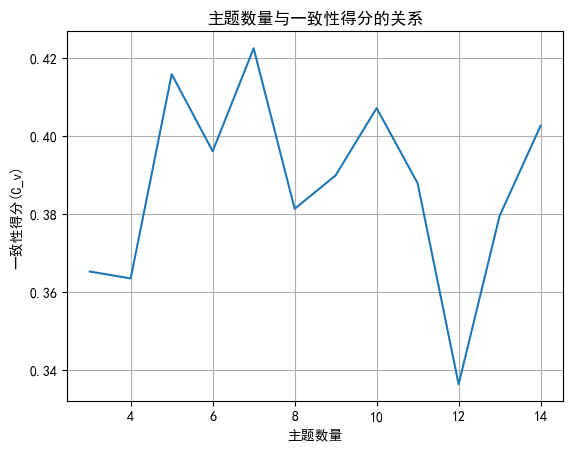

In [41]:
# (高级) 探索不同主题数的效果
# 你可以写一个循环，尝试不同的num_topics值（例如3到15），
# 每次训练模型并计算C_v得分，然后画出得分随主题数变化的曲线，
# 找到得分较高或曲线拐点处的主题数作为较优选择。
def compute_coherence_values(dictionary, corpus, documents , limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaModel(
            corpus= corpus, # 训练语料
            id2word=dictionary, # 词典，用于解释主题
            num_topics=num_topics, # 指定主题数量
            random_state=42 , # 设置一个确定的初始状态，排除随机化带来的干扰
            update_every=1, # 每处理多少文档更新一次模型
            chunksize=100, # 每次处理的文档块大小
            passes=10, # 整个语料库的训练遍历次数

            alpha="auto", # 自动学习alpha参数
            eta="auto", # 自动学习eta参数
            per_word_topics=True # 计算每个词属于哪个主题的概率
            # 注意: 计算C_v时 per_word_topics=True 可能不是必需的，有时甚至会报错或影响性能，可以考虑设为 False 试试
            # per_word_topics=False # 尝试改为 False 看看是否有影响
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=documents, dictionary=dictionary, coherence='c_v')
        # 计算得分
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values
start = 3
limit = 15
step = 1
model_list, coherence_values = compute_coherence_values(dictionary,corpus,documents,limit, start, step)
# plot the graph
plt.plot(range(start, limit, step), coherence_values)
plt.xlabel("主题数量")
plt.ylabel("一致性得分(C_v)")
plt.title("主题数量与一致性得分的关系")
plt.grid()
plt.show()


开始计算不同主题数 (从 3 到 15，步长 1) 的一致性得分...
  训练 LDA 模型，主题数 = 3 ...
  计算 主题数 = 3 的 C_v 得分...
  主题数 = 3 的 C_v 得分 = 0.3653
  训练 LDA 模型，主题数 = 4 ...
  计算 主题数 = 4 的 C_v 得分...
  主题数 = 4 的 C_v 得分 = 0.3635
  训练 LDA 模型，主题数 = 5 ...
  计算 主题数 = 5 的 C_v 得分...
  主题数 = 5 的 C_v 得分 = 0.4159
  训练 LDA 模型，主题数 = 6 ...
  计算 主题数 = 6 的 C_v 得分...
  主题数 = 6 的 C_v 得分 = 0.3961
  训练 LDA 模型，主题数 = 7 ...
  计算 主题数 = 7 的 C_v 得分...
  主题数 = 7 的 C_v 得分 = 0.4225
  训练 LDA 模型，主题数 = 8 ...
  计算 主题数 = 8 的 C_v 得分...
  主题数 = 8 的 C_v 得分 = 0.3813
  训练 LDA 模型，主题数 = 9 ...
  计算 主题数 = 9 的 C_v 得分...
  主题数 = 9 的 C_v 得分 = 0.3899
  训练 LDA 模型，主题数 = 10 ...
  计算 主题数 = 10 的 C_v 得分...
  主题数 = 10 的 C_v 得分 = 0.4072
  训练 LDA 模型，主题数 = 11 ...
  计算 主题数 = 11 的 C_v 得分...
  主题数 = 11 的 C_v 得分 = 0.3879
  训练 LDA 模型，主题数 = 12 ...
  计算 主题数 = 12 的 C_v 得分...
  主题数 = 12 的 C_v 得分 = 0.3363
  训练 LDA 模型，主题数 = 13 ...
  计算 主题数 = 13 的 C_v 得分...
  主题数 = 13 的 C_v 得分 = 0.3795
  训练 LDA 模型，主题数 = 14 ...
  计算 主题数 = 14 的 C_v 得分...
  主题数 = 14 的 C_v 得分 = 0.4026
  训练 LDA 模型，主题数 = 15 ...


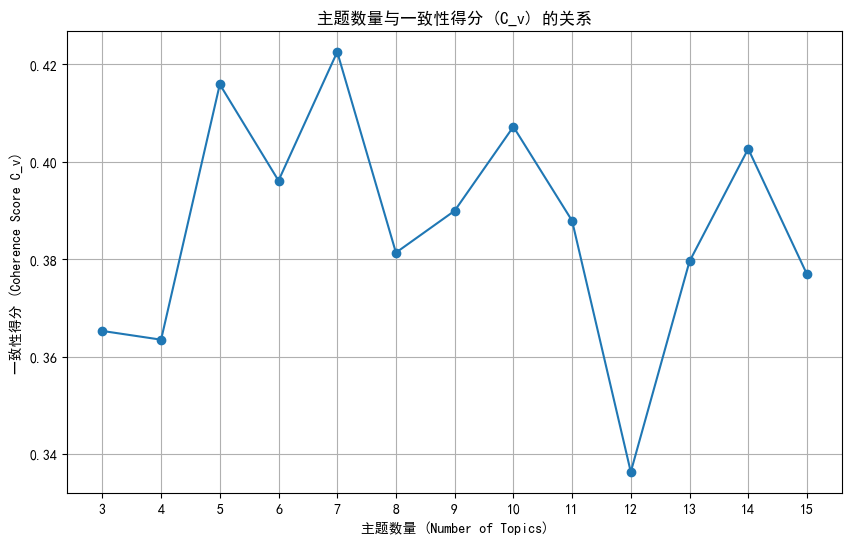


在测试范围内，C_v得分最高的主题数是: 7 (得分: 0.4225)
注意：一致性得分只是参考，最佳主题数还需结合主题的可解释性来判断。


In [ ]:
# 增强版：增加循环提示,可以明确看到循环运行过程
def compute_coherence_values(dictionary, corpus, documents, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    print(f"开始计算不同主题数 (从 {start} 到 {limit-1}，步长 {step}) 的一致性得分...") #####
    for num_topics in range(start, limit, step):
        print(f"  训练 LDA 模型，主题数 = {num_topics} ...") #####
        # 训练当前主题数的模型
        model = models.LdaModel(  # 使用当前循环的 num_topics
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics, # 使用循环变量 num_topics
            random_state=42,
            update_every=1,
            chunksize=100,
            passes=1,            
            per_word_topics=True # 注意: 计算C_v时 per_word_topics=True 可能不是必需的，有时甚至会报错或影响性能，可以考虑设为 False 试试
            # per_word_topics=False # 尝试改为 False 看看是否有影响
        )
        model_list.append(model)

        print(f"  计算 主题数 = {num_topics} 的 C_v 得分...") #####
        coherencemodel = CoherenceModel(
            model=model, # !!! 这里使用 model (小写)，而不是固定的 lda_model !!!
            texts=documents,
            dictionary=dictionary,
            coherence='c_v'
        )
        # 获取得分
        coherence_score = coherencemodel.get_coherence()
        coherence_values.append(coherence_score)
        print(f"  主题数 = {num_topics} 的 C_v 得分 = {coherence_score:.4f}")

    print("一致性得分计算完成。")
    return model_list, coherence_values

# --- 调用函数并绘图 (假设 dictionary, corpus, documents 已准备好) ---
start = 3
limit = 16 # 尝试几个不同的主题数，例如到15个，注意range()的上限是排除的
step = 1   # 每次增加1个主题
num_topics_range = list(range(start, limit, step))

if dictionary and corpus and documents: # 确保输入有效
    model_list, coherence_values = compute_coherence_values(dictionary, corpus, documents, limit, start, step)

    # 绘制得分曲线[增强版图像]
    if coherence_values: # 确保列表非空
        plt.figure(figsize=(10, 6))
        plt.plot(num_topics_range, coherence_values, marker='o') # 使用实际的主题数范围作为x轴
        plt.xlabel("主题数量 (Number of Topics)")
        plt.ylabel("一致性得分 (Coherence Score C_v)")
        plt.title("主题数量与一致性得分 (C_v) 的关系")
        plt.xticks(num_topics_range) # 让x轴刻度对应主题数
        plt.grid(True)
        plt.savefig('lda_coherence_plot.png') # 保存图表
        plt.show()

        # 找出得分最高的点 (但不一定是最好的主题数，还要看主题内容)
        if coherence_values:
            max_coherence = max(coherence_values)
            optimal_topics_index = coherence_values.index(max_coherence)
            optimal_topics = num_topics_range[optimal_topics_index]
            print(f"\n在测试范围内，C_v得分最高的主题数是: {optimal_topics} (得分: {max_coherence:.4f})")
            print("注意：一致性得分只是参考，最佳主题数还需结合主题的可解释性来判断。")
    else:
        print("未能计算出一致性得分。")

else:
    print("错误：dictionary, corpus 或 documents 未正确准备好，无法计算一致性。")

#### 第7步：文本摘要(summarization)——Hugging Face
- **操作**：使用预训练的**序列到序列（Seq2Seq）模型**，对新闻的`summary`或`full_text`进行自动摘要
- **原因与依据:**
    - **LLM核心能力**: 文本摘要是*大型语言模型（特别是生成式模型）*的核心应用之一，能将长文本压缩成关键信息，非常实用。
    - **`Hugging Face Pipeline`**: 同样使用`pipeline("summarization", ...)`简化调用。

    - **模型选择**: `csebuetnlp/mT5_m2o_chinese_simplified_crossSum` 是一个*基于mT5且专门为中文摘要任务微调*的模型，效果相对可靠。
    - **参数调整**: 摘要效果可以通过调整**min_length, max_length, do_sample, num_beams**等参数来优化，代码中给出了**基本设置**，并**注释了可选的高级参数**。
    - **性能**: **摘要是生成任务，计算量远大于分类任务（如情感分析、NER）**，因此默认只对少量样本进行演示，避免用户等待过长时间。提供了对全体数据处理的选项，但附带了明确的耗时警告。
    - **输入**: 摘要任务通常输入*原始文本（或稍微清洗过的文本）* 效果较好，模型内部会进行必要的处理。

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM # 标准导入
import pandas as pd # 假设你需要处理DataFrame
from tqdm.notebook import tqdm # 用于进度条
import re # README 中用到了

# --- 1. 定义文本预处理器 (来自README) ---
WHITESPACE_HANDLER = lambda k: re.sub('\s+', ' ', re.sub('\n+', ' ', k.strip()))

# --- 2. 加载模型和分词器 ---
model_name_mT5 = "csebuetnlp/mT5_m2o_chinese_simplified_crossSum" # 新的模型名称
tokenizer_mT5 = None
model_mT5 = None
device_mT5 = None # 用于后续将模型和数据移到GPU

try:
    print(f"正在加载新的摘要模型和分词器: {model_name_mT5} ...")
    tokenizer_mT5 = AutoTokenizer.from_pretrained(model_name_mT5)
    model_mT5 = AutoModelForSeq2SeqLM.from_pretrained(model_name_mT5)
    print("新的摘要模型和分词器加载成功。")

    # --- 检查GPU并将模型移动到GPU ---
    if torch.cuda.is_available():
        device_mT5 = torch.device("cuda:0")
        model_mT5.to(device_mT5)
        print("mT5模型已移动到 GPU。")
    else:
        device_mT5 = torch.device("cpu")
        print("mT5模型将在 CPU 上运行。")

except Exception as e:
    print(f"加载 mT5 模型或分词器时出错: {e}")
    print("请检查模型名称是否正确、网络连接是否正常。")
    # 如果加载失败，后续摘要功能将不可用
    # 你可以选择在这里 exit() 或设置一个标志位

# --- 3. 定义新的摘要函数 (基于README示例) ---
def generate_summary_mT5(text, min_length_ratio=0.1, max_length_ratio=0.5, default_max_len=84):
    """
    使用 csebuetnlp/mT5_m2o_chinese_simplified_crossSum 模型生成摘要。
    min_length_ratio 和 max_length_ratio 是相对于原始文本长度的比例。
    default_max_len 是在文本非常短或计算比例不合适时的默认最大摘要长度。
    """
    if not model_mT5 or not tokenizer_mT5 or not device_mT5: # 确保模型已加载
        print("错误：mT5模型或分词器未成功加载，无法生成摘要。")
        return "摘要模型未加载"

    if not isinstance(text, str) or pd.isna(text):
        return "无效输入文本"

    # 使用README中的空白处理
    cleaned_text = WHITESPACE_HANDLER(text)
    if len(cleaned_text) < 10: # 文本太短可能无法有效摘要
        return "原始文本过短"

    try:
        # --- 编码输入文本 ---
        # mT5 通常能处理较长输入，但仍建议设置一个上限，如README中的512
        # 这里我们使用 return_tensors="pt"
        input_ids = tokenizer_mT5(
            [cleaned_text], # 注意输入需要是列表
            return_tensors="pt",
            padding="max_length", # 或 True，让模型自己决定填充策略
            truncation=True,
            max_length=512 # 这是编码器的最大输入长度
        )["input_ids"].to(device_mT5) # 将编码后的tensor移动到GPU

        # --- 动态计算摘要长度 (可选但推荐) ---
        # README 中固定了 max_length=84，但对于不同长度的输入，动态调整可能更好
        text_length = len(cleaned_text.split()) # 简单按空格分词计数
        calculated_max_length = max(int(text_length * max_length_ratio), 20) # 摘要最大20词
        calculated_max_length = min(calculated_max_length, default_max_len * 2) # 设一个上限，比如默认最大长度的2倍
        calculated_min_length = max(int(text_length * min_length_ratio), 10) # 摘要最少10词

        # --- 生成摘要 ---
        output_ids = model_mT5.generate(
            input_ids=input_ids,
            max_length=calculated_max_length,    # 解码器的最大输出长度 (摘要长度)
            min_length=calculated_min_length,    # 摘要的最小长度
            no_repeat_ngram_size=2, # 避免重复的n-gram
            num_beams=4,            # 使用Beam Search，通常能提高摘要质量
            early_stopping=True     # 当Beam Search找到足够好的结果时提前停止
        )[0] # 获取第一个（也是唯一一个）结果

        # --- 解码摘要 ---
        summary = tokenizer_mT5.decode(
            output_ids,
            skip_special_tokens=True,
            clean_up_tokenization_spaces=False # 与README保持一致
        )
        return summary

    except Exception as e:
        print(f"生成摘要时发生错误 (mT5): {e}")
        return "摘要生成失败"

# --- 4. 测试新的摘要函数 ---
# if model_mT5 and tokenizer_mT5: # 确保模型加载成功再测试
#     test_article_text = """Videos that say approved vaccines are dangerous and cause autism, cancer or infertility are among those that will be taken down, the company said.  The policy includes the termination of accounts of anti-vaccine influencers.  Tech giants have been criticised for not doing more to counter false health information on their sites.  In July, US President Joe Biden said social media platforms were largely responsible for people's scepticism in getting vaccinated by spreading misinformation, and appealed for them to address the issue.  YouTube, which is owned by Google, said 130,000 videos were removed from its platform since last year, when it implemented a ban on content spreading misinformation about Covid vaccines.  In a blog post, the company said it had seen false claims about Covid jabs "spill over into misinformation about vaccines in general". The new policy covers long-approved vaccines, such as those against measles or hepatitis B.  "We're expanding our medical misinformation policies on YouTube with new guidelines on currently administered vaccines that are approved and confirmed to be safe and effective by local health authorities and the WHO," the post said, referring to the World Health Organization."""
#     print("\n--- 测试 mT5 摘要功能 ---")
#     print("测试原文 (英文):")
#     print(test_article_text)
#     mT5_summary = generate_summary_mT5(test_article_text, default_max_len=84) # 使用README中的默认最大长度
#     print("\nmT5 生成的中文摘要:")
#     print(mT5_summary)

#     chinese_test_text = "中国发改委反垄断调查小组突击查访奔驰上海办事处，调取数据材料，并对多名奔驰高管进行了约谈。"
#     print("\n测试原文 (中文):")
#     print(chinese_test_text)
#     mT5_summary_chinese = generate_summary_mT5(chinese_test_text, default_max_len=50) # 中文摘要可以短一些
#     print("\nmT5 对中文文本生成的中文摘要:")
#     print(mT5_summary_chinese)


# --- 5. 应用到我们的DataFrame ---

if model_mT5 and tokenizer_mT5 and 'df' in locals() and 'full_text' in df.columns:
    print("\n--- 将 mT5 摘要应用到DataFrame (示例前5条) ---")
    sample_df_mT5 = df.head(5).copy() # 可调整数量，视显存资源选择
    tqdm.pandas(desc="Generating mT5 Summaries")
    sample_df_mT5['generated_summary_mT5'] = sample_df_mT5['full_text'].progress_apply(
        lambda x: generate_summary_mT5(x, default_max_len=60) # 可以调整摘要长度，视显存资源选择，最大值为84
    )
    print(sample_df_mT5[['full_text', 'generated_summary_mT5']])
else:
    if 'df' not in locals():
        print("\nDataFrame 'df' 未定义，跳过应用到DataFrame的步骤。")
    elif 'full_text' not in df.columns:
        print("\nDataFrame 'df' 中缺少 'full_text' 列，跳过应用到DataFrame的步骤。")

正在加载新的摘要模型和分词器: csebuetnlp/mT5_m2o_chinese_simplified_crossSum ...


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


新的摘要模型和分词器加载成功。
mT5模型已移动到 GPU。

--- 将 mT5 摘要应用到DataFrame (示例前10条) ---


Generating mT5 Summaries:   0%|          | 0/5 [00:00<?, ?it/s]

                                           full_text  \
0  我们不惹事，也不怕事 来源：央视网 美国对全球滥施关税的“余震”还在继续，全球经济遭遇“黑色...   
1  海关总署：4月10日12时01分起，执行对原产于美国的进口商品加征84%关税 海关总署4月9...   
2  北京市气象台发布重要天气提示信息 受冷涡加强东移南下影响，11日下午至13日我市将出现一次极...   
3  极端大风➕强降温！明天上午北京将提前发布大风橙色预警信号 北京市气象台9日夜间介绍，受冷涡加...   
4  教育部发布2025年第1号留学预警 近日，美国俄亥俄州通过有关高等教育法案，其中包含涉华消极...   

                      generated_summary_mT5  
0             <extra_id_59> 中国金融业不景气,股市不看好。  
1   <extra_id_59> 中国海关总署在4月10日宣布调整对原产于美国的进口  
2  <extra_id_59> 中国首都北京周日(11月11日)迎来一连串大风天气。  
3      <extra_id_59> 强风暴雨吹袭北京,9日早上北京将出现极端大风  
4        <extra_id_59> 中国教育部发布2025年第1号留学预警。  
